In [4]:
import pandas as pd
import numpy as np
from scipy import stats,optimize,interpolate,integrate
import matplotlib.pyplot as plt
import math
import matplotlib.gridspec as gridspec

In [8]:
def plot_bar(city_name='all',numb='all',Y1=1939,Y2=2022,show=True):
    if city_name!='all':
        lc=lotto[(lotto.city==city_name)&(lotto['dt'].dt.year<=Y2)&(lotto['dt'].dt.year>=Y1)].copy()
    else:
        lc=lotto[(lotto['dt'].dt.year<=Y2)&(lotto['dt'].dt.year>=Y1)].copy()
        city_name='Totale'
    if numb=='all':
        SC=pd.Series(lc[['1','2','3','4','5']].squeeze().values.ravel())
        numb='Tutte'
    else:
        SC=lc[numb]
    cs=SC.value_counts().sort_index()
    if show:
        cs.plot(kind='bar',figsize=(16,9),title='Conteggio estrazioni dal {} al {}, {}, estrazione {}'.format(Y1,Y2,city_name,numb),xlabel=r'N',ylabel=r'Conteggi')
    return cs

def cvals(array):
    return array[:-1]+np.diff(array)/2

def chi2_test(counts_lotto,alpha=0.05,show=False,title='',col='black'):
    unif_counts=pd.Series( dict((i,model.pmf(i)*counts_lotto.sum()) for i in range(1,91)) )
    testchi2=pd.DataFrame( dict( exp=unif_counts,obs=counts_lotto.values ) )
    testchi2['res']=testchi2['obs']-testchi2['exp']
    testchi2['res2']=testchi2['res']**2
    testchi2['res2_norm']=testchi2['res2']/testchi2['exp']
    chi2=testchi2['res2_norm'].sum()
    dof=90-1
    p2=stats.chi2.sf(chi2,dof)
    if show:
        plt.figure(figsize=(12,10),dpi=150)
        plt.bar(counts_lotto.index,counts_lotto.values,color=col,zorder=100,width=0.3,label='observed')
        plt.bar(counts_lotto.index,testchi2.exp.values,color='red',alpha=0.5,label='expected')
        plt.xticks(counts_lotto.index[0:94:5])
        plt.xlabel('N')
        plt.ylabel('Conteggi')
        plt.title(title)
        plt.legend()
        plt.show()
        print('chi2/dof: {:.2f}/{:.2f}'.format(chi2,dof))
        print('p value: ', p2)
        print('Z = {:.2f}σ'.format(-stats.norm.ppf(p2)))
        print('')
        print(testchi2)
        print('p < α = {} : {}'.format(alpha,p2<alpha))
    return (pd.DataFrame(dict(chi2=chi2,dof=dof,p=p2,Z=-stats.norm.ppf(p2)),index=[0]),testchi2)
def plot_fit(test,a,b):
    plt.figure(figsize=(15,10),dpi=100)
    plt.scatter(test.index,test['res']/np.sqrt(test['exp']))
    plt.plot([0,90],[b,a*90+b], c='red' )
    plt.title('Residui normalizzati')
    plt.xlabel('Numeri estratti')
    plt.ylabel(r'$r_{norm}$')
    plt.show()


## Introduzione

La seguente analisi si propone di verificare se le estrazioni del lotto siano uniformi. L'estrazione del lotto consiste nell'estrazione senza rimessa di 5 numeri da un'urna, dove ogni numero ha la stessa probabilità di essere estratto, ovvero: $$p= \frac{\binom{89}{4}}{\binom{90}{5}}= \frac{1}{18}$$. 
Per verificare tale ipotesi è stato applicato il test del $\chi^2$ a vari fasce temporali e alle varie ruote. Prima di procedere con i test si è simulato un'ulteriore ruota con un toy Montecarlo per usarlo come campione di riferimento nei vari test. 

Importiamo i dati dall'archivio storico del lotto italiano con pandas.

In [3]:
lotto=pd.read_csv(r'ArchivioLotto.Italia.csv',delimiter=';',names=['date','city','1','2','3','4','5'])
lotto=lotto.replace(lotto['city'][1],'NA')
lotto['dt']=pd.to_datetime(lotto['date'],format="%d/%m/%Y")
lotto

,date,city,1,2,3,4,5,dt
0,28/01/1939,MI,47,85,18,38,50,1939-01-28
1,28/01/1939,NA,73,34,8,39,17,1939-01-28
2,28/01/1939,PA,52,25,63,84,60,1939-01-28
3,28/01/1939,RO,56,87,82,90,53,1939-01-28
4,28/01/1939,TO,27,48,40,33,67,1939-01-28
...,...,...,...,...,...,...,...,...
68059,16/07/2022,PA,32,4,45,25,3,2022-07-16
68060,16/07/2022,RO,61,89,27,22,85,2022-07-16
68061,16/07/2022,TO,88,43,17,77,54,2022-07-16
68062,16/07/2022,VE,40,82,80,35,41,2022-07-16


Generiamo ora una sequenza di numeri ottenuti dalle estrazione di un lotto simulato.
Si sono simulate estrazioni ripetute da una ruota in condizioni ideali (i.e. con probabilità uniforme di estrazione del singolo numero). Il valore atteso di conteggi per ciascun è: $\displaystyle \mu = \frac{N}{90}$ con N il numero totale di numeri estratti o anche $\displaystyle \mu=\frac{1}{18} \frac{1}{5} N=\frac{N}{90}$

Definiamo la funzione estrazione di cinque numeri senza rimessa da una ruota.

In [5]:
model=stats.randint(low=1,high=91,loc=0)
def estrazioni_senza_rimessa(n,m):
    res=np.empty(m)
    numbers=np.array(range(1,n+1))
    for k in range(m):
        ind=stats.randint.rvs(low=0,high=n-k)
        res[k]=numbers[ind]
        numbers=np.delete(numbers,ind)
    return res
estr_lotto=lambda: estrazioni_senza_rimessa(90,5)

Rappresentiamo graficamente i risultati della simulazione

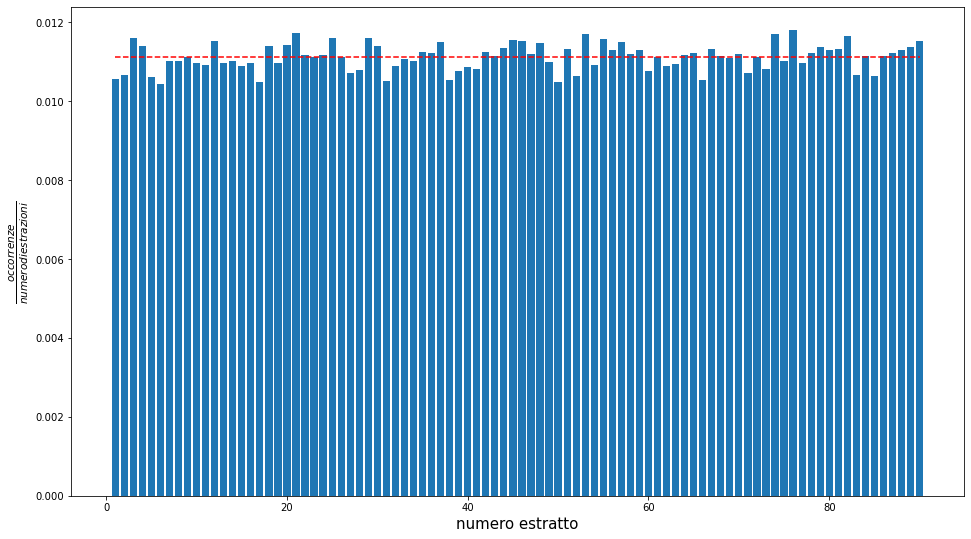

In [7]:
counts_estr_lotto=dict((i,0) for i in range(1,91))
N=10000
for i in range(N):
    ext=estr_lotto()
    extvals,count_i=np.unique(ext,return_counts=True)
    for e,c in zip(extvals,count_i):
        counts_estr_lotto[e]+=c
counts_estr_lotto=pd.Series( counts_estr_lotto )
plt.figure(figsize=(16,9))
plt.bar(counts_estr_lotto.index,counts_estr_lotto/counts_estr_lotto.sum())
plt.xlabel('numero estratto',fontsize=15)
plt.ylabel(r'$\frac{occorrenze}{numero di estrazioni}$',fontsize=15)
plt.plot([1,90], 1/90 * np.ones(2), c='red', linestyle='--')
plt.show(7)

## Test preliminare
La prima analisi viene condotta sul campione completo delle estrazioni da tutte le ruote dal 1939 al 2022. Si usa la funzione plot_bar definita prima per graficare l'istogramma dei conteggi e per conservare gli stessi in una Series pandas.

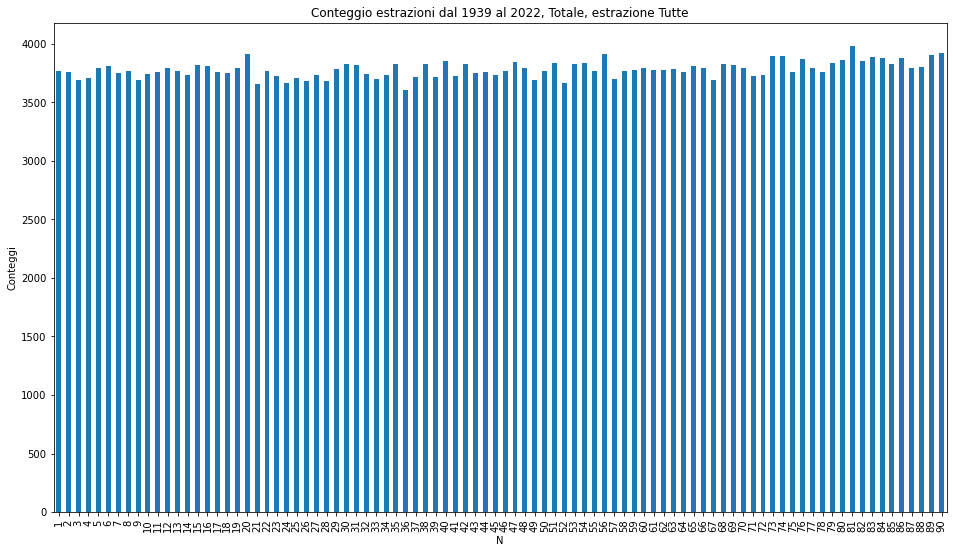

In [10]:
cont0 = plot_bar()

Si effettua ora un test del $\chi^2$ sul campione considerato usando la funzione chi2_test sopra definita, che esegue un test del $\chi^2$ contro l'ipotesi nulla $H_0$ che la distribuzione in esame sia uniforme tra i valori 1-90, con significatività $\alpha=0.05$.

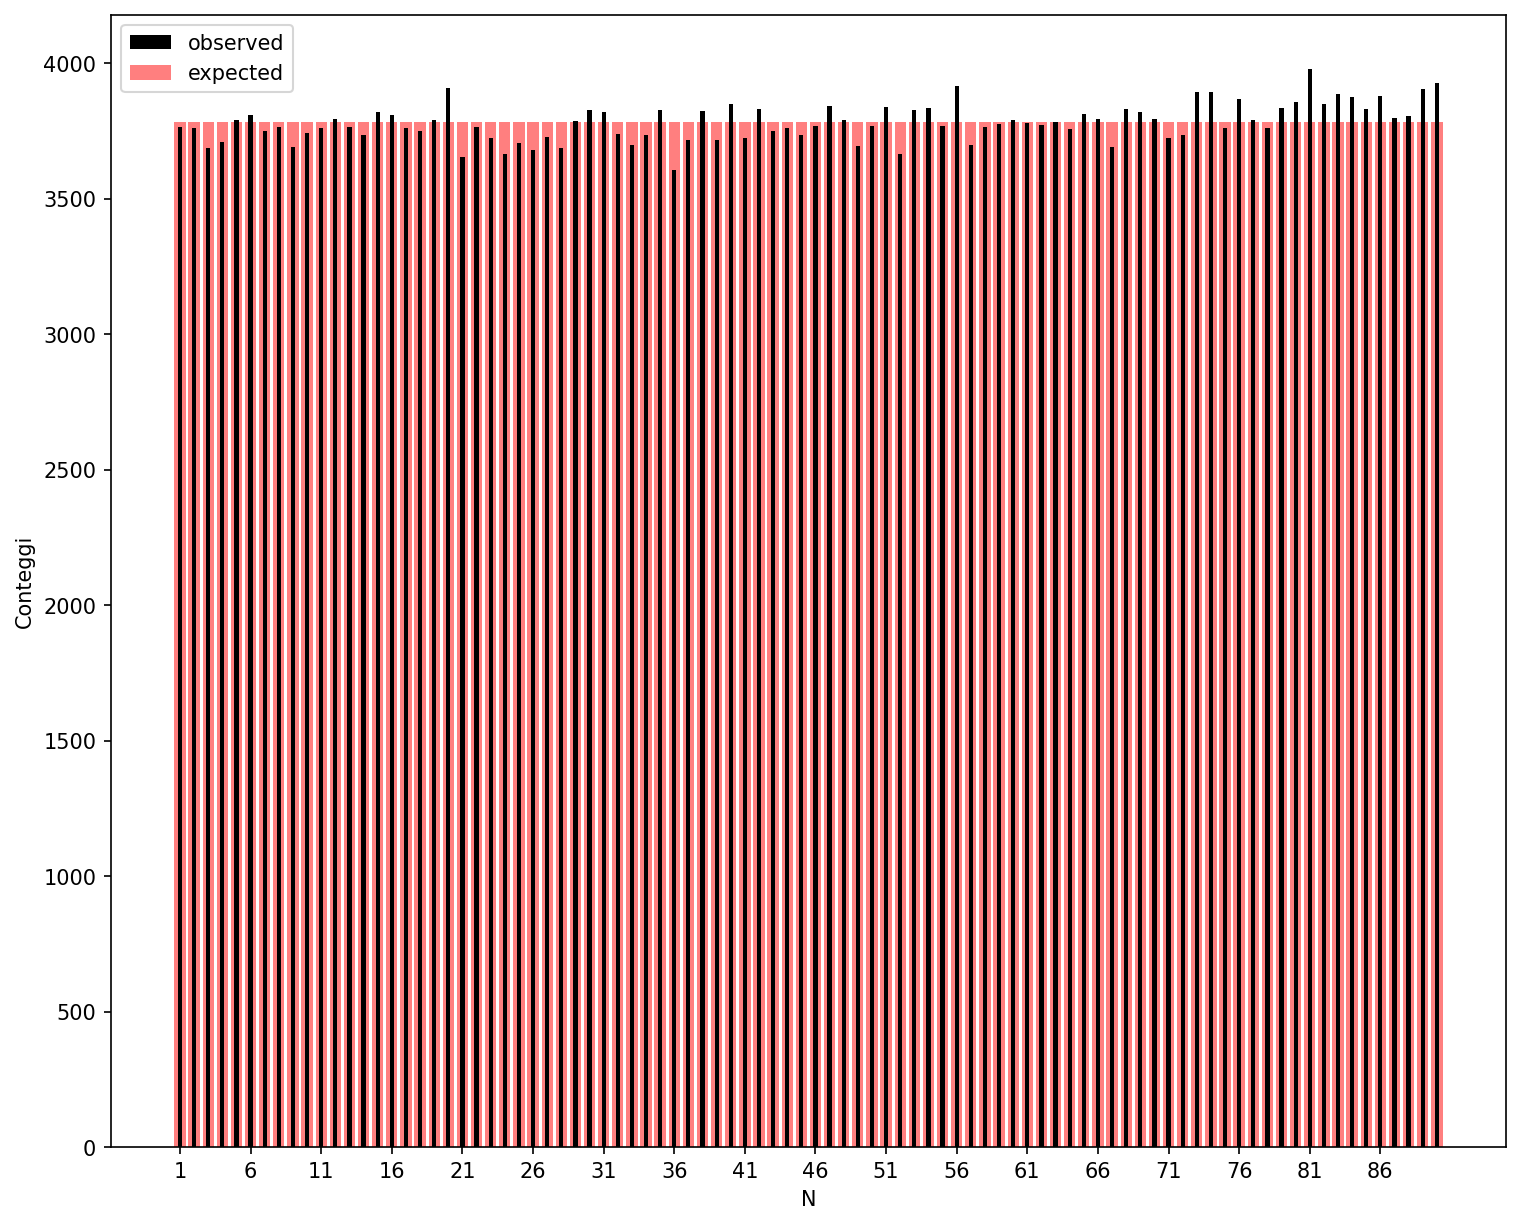

chi2/dof: 109.84/89.00
p value:  0.06631366615029967
Z = 1.50σ

            exp   obs         res          res2  res2_norm
1   3781.333333  3765  -16.333333    266.777778   0.070551
2   3781.333333  3761  -20.333333    413.444444   0.109338
3   3781.333333  3688  -93.333333   8711.111111   2.303714
4   3781.333333  3707  -74.333333   5525.444444   1.461242
5   3781.333333  3789    7.666667     58.777778   0.015544
..          ...   ...         ...           ...        ...
86  3781.333333  3877   95.666667   9152.111111   2.420340
87  3781.333333  3797   15.666667    245.444444   0.064909
88  3781.333333  3803   21.666667    469.444444   0.124148
89  3781.333333  3905  123.666667  15293.444444   4.044458
90  3781.333333  3925  143.666667  20640.111111   5.458421

[90 rows x 5 columns]
p < α = 0.05 : False


In [11]:
test0a,test0b =chi2_test(cont0,show=True)

Dall'esito del test appena condotto si ottien un valore del $\chi^2=109.84$ contro $\mathrm{dof}=90-1$, poiché il numeri di classi utilizzato è 90, con $p=0.066<\alpha$, dunque non possiamo escludere l'ipotesi che la distribuzione delle estrazioni sia uniforme con significatività $\alpha=0.05$; da un'osservazione prettamente grafica, emerge però che l'istogramma risulta lievemente pendente verso sinistra. Nonostante l'esito del test condotto, si prosegue con l'analisi. Poiché il $\chi^2$ non è sensibile al segno dei residui, si ha qui interesse nell'analizzare questi separatamente. Spinti dal sospetto che i numeri più alti tendano a essere estratti di più, si effettua una regressione lineare sui residui normalizzati $\displaystyle r_i=\frac{(n_i - n_i^{\mathrm{exp}})}{ \sqrt{n_i^{\mathrm{exp}}}} $ (dove $n_i$ rappresenta il conteggio della singola classe, $n_i^{\mathrm{exp}}$ il valore atteso dei conteggi che, nel caso uniforme, è dato dal prodotto tra il numero totale di conteggi $N$ e la $\mathrm{pmf}$ discreta uniforme valutata nel valore corrispondente alla classe; evidentemente, i valori attesi saranno uguali per tutte le classi) per avere, dal segno del coefficiente di Pearson fornito dalla funzione linregress, un'indicazione sul comportamento dei residui. Inoltre, la funzione restituisce anche il p-value associato all'ipotesi nulla che la pendenza sia nulla.

Definiamo una funzione che restituisca i valori di interesse per l'analisi a partire da una regressione lineare.

In [55]:
def linreg(series,show=True):
    s,i,r,p,std1=stats.linregress(series.index,series.values)
    if show:
        print('slope : ',s,'intercept :',i,'r (Pearson) : ',r,'p (H0 : slope=0): ',p)
    return (s,i,r,p)

In [30]:
a,b,r,p=linreg(test0b['res']/np.sqrt(test0b['exp']))

slope :  0.020003421308375482 intercept : -0.9101556695310868 r (Pearson) :  0.4703940340641528 p (H0 : slope=0):  2.8934076733577544e-06


Grafichiamo i risultati.

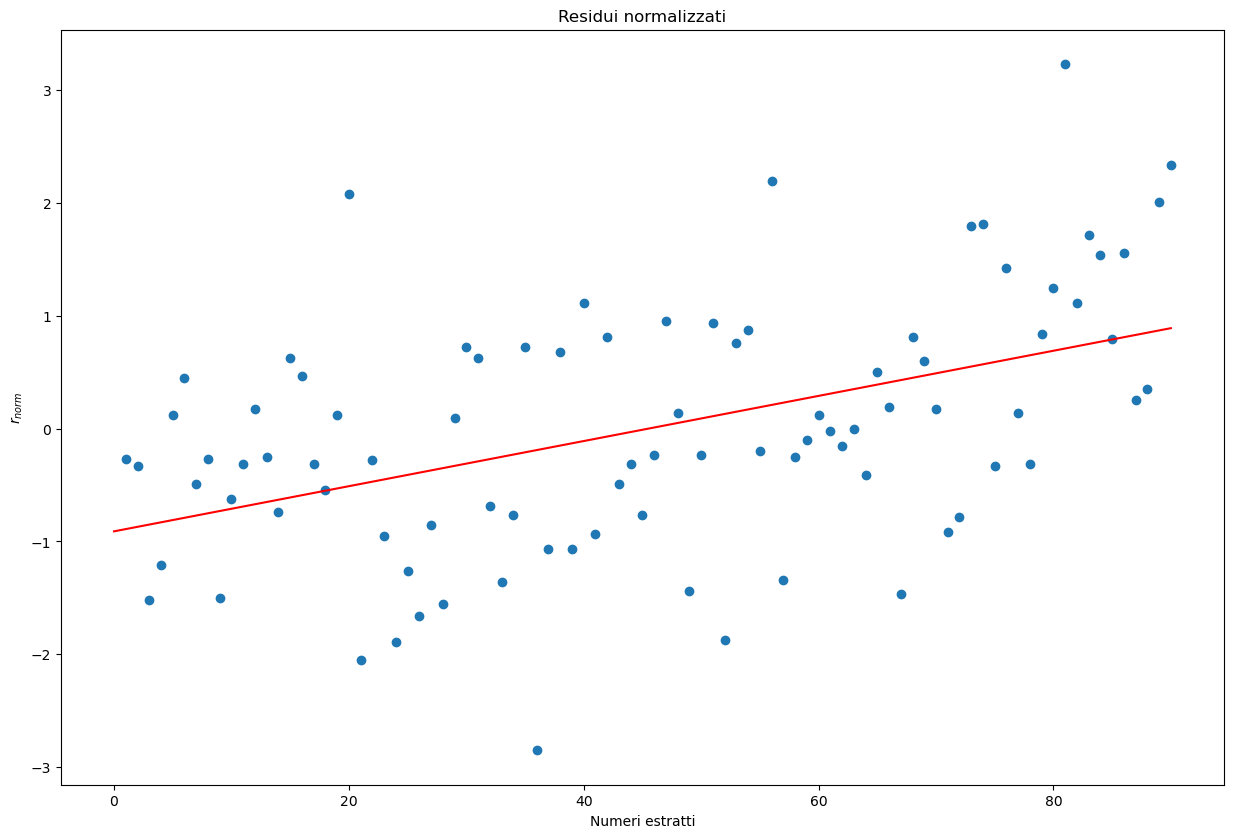

In [31]:
plot_fit(test0b,a,b)

Come si vede la tendenza dei residui è di crescere più alto è il numero estratto, con coefficiente di correlazione di Pearson pari a $r=0.47$ (ci si aspetta, ovviamente, un valore nullo sotto l'ipotesi di distribuzione uniforme). Nonostante quindi il test del $\chi^2$ condotto prima non permetta di escludere l'ipotesi nulla $H_0$ che il campiome sia uniforme, è ragionevole il sospetto che ci sia una maggiore tendenza a estrarre numeri più alti. Sulla base di queste considerazioni, si procede con ulteriori test. Esistono molteplici ipotesi di lavoro: si può supporre, ad esempio, che la scala temporale su cui si sono analizzati i dati riportati sopra sia tale da coprire campioni estratti da diverse distribuzioni (e.g. nella storia del lotto si sono modificate le condizioni di estrazione e ciò può dividere il campione totale considerato in due estratti secondo regole diverse); un'altra ipotesi è che nelle cinque estrazioni successive nelle ruote esistano differenze dovute ancora a metodi di estrazioni non ottimali; ancora, alcune ruote potrebbero essere difettose rispetto ad altre; potrebbe esistere una combinazione di questi effetti. Si procede con l'analisi separatamente di questi effetti con la divisione in sotto-campioni.

In questa parte dell'analisi si valuterà l'effetto di ciascuna ruota presa singolarmente. Ci aspettiamo che, in caso di difetto di una di queste, la tendenza sopra osservata sia molto alta per una delle ruota e, nell'ipotesi in cui le altre seguano il modello atteso, per le altre trascurabile.

## $\textbf{Ruota di Napoli}$

Implementiamo ora le funzioni che utilizzeremo nel seguito per effettuare rispettivamente plot di grafici a barre e test del $\chi^2$. Per facilitare l'analisi spiegata è stata definita la funzione analisi, facendo uso della libreria matplotlib.gridspec per la gestione dei vari plot.


In [32]:
def analisi(nome_citta='all',numb='all',Y1=1939,Y2=2022):
    plt.figure(figsize=(16,21),dpi=100)
    gs = gridspec.GridSpec(15, 1)
    cont = plot_bar(city_name=nome_citta,numb=numb,Y1=Y1,Y2=Y2,show=False)
    testa,testb = chi2_test(cont,show=False)
    residuinorm,numeri=testb.res/testb.exp,testb.index
    frequenze=testb.obs
    a,b,r,p=linreg(residuinorm)
    ax0 = plt.subplot(gs[:6, :])
    ax1 = plt.subplot(gs[7:, :])
    ax0.bar(numeri,frequenze,zorder=100,color='black',width=0.3,label='obs')
    ax0.bar(cont.index,testb.exp.values,color='red',alpha=0.5,label='expected')
    ax0.legend()
    ax0.set_title(r'Estrazioni dal {} al {} (ruota {}), n. pescaggio {}'.format(Y1,Y2,nome_citta,numb))
    ax0.set_xlabel('N')
    ax0.set_ylabel('Conteggi')
    ax1.scatter(numeri,residuinorm)
    ax1.plot([1,90],[a*1+b,a*90+b],color='red')
    ax1.set_title('Reg. lin. dei residui norm.')
    ax1.set_xlabel('N')
    ax1.set_ylabel(r'$\frac{(n_i - n_i^{\mathrm{exp}})}{ \sqrt{n_i^{\mathrm{exp}}}}$')
    print('p value (test del chi quadro):', testa['p'].values)
    print('p value (test su pendenza):', p)
    plt.show()

In essa sono contenuti due test: il test del $\chi^2$ e un test di ipotesi condotto sul valore della pendenza della regressione tramite funzione scipy.stats.linregress, entrambi con significatività posta a $\alpha=0.05$.

slope :  0.00012261270441292667 intercept : -0.005578878050788163 r (Pearson) :  0.0649136961582618 p (H0 : slope=0):  0.543281173723525
p value (test del chi quadro): [0.76989104]
p value (test su pendenza): 0.543281173723525


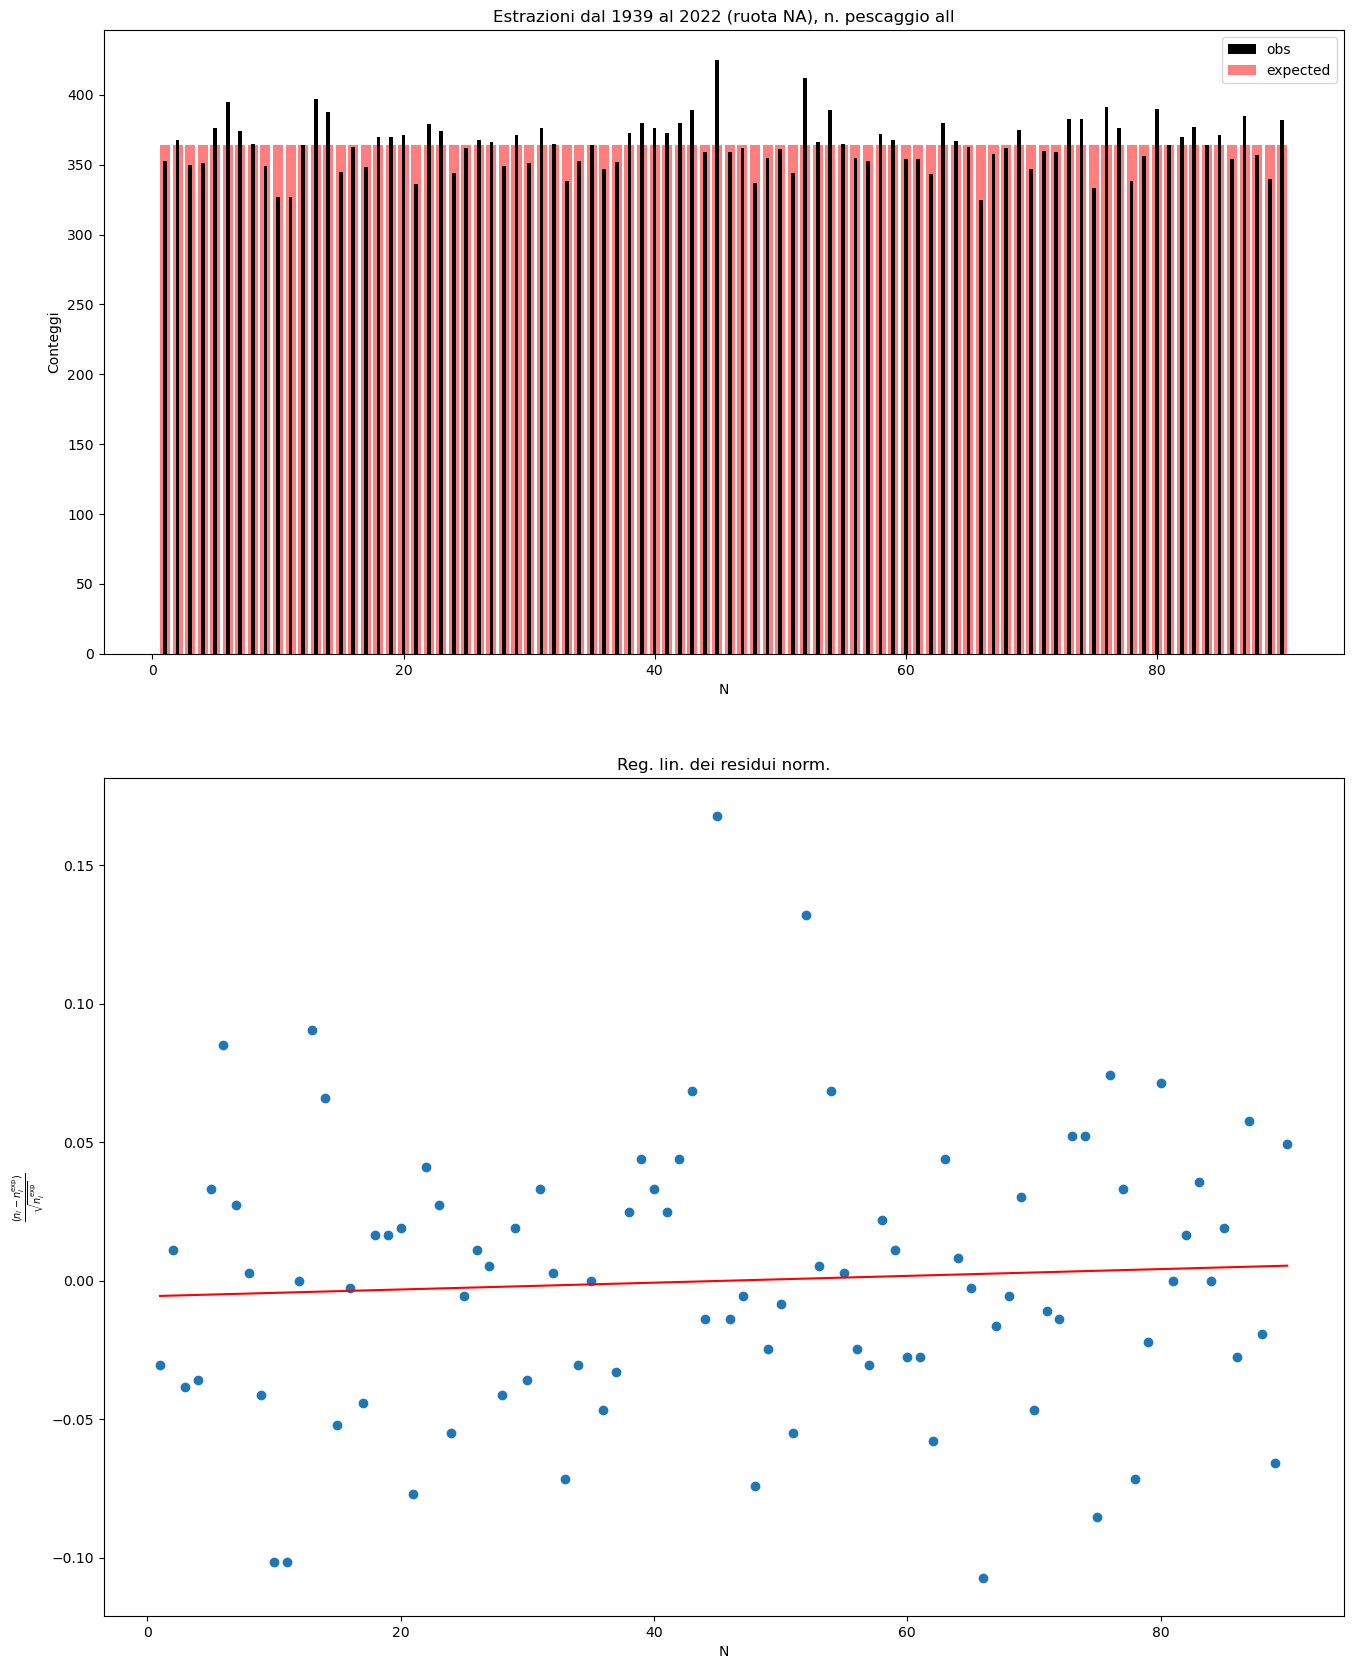

In [34]:
analisi(nome_citta='NA',Y1=1939,Y2=2022)

Dalla precedente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Napoli tra il 1939 e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri e il coefficiente $r$ è minore rispetto al caso precedente, in particolare vale che $p_{\mathrm{slope}}>0.05$, quindi non si rigetta l'ipotesi che la pendenza sia nulla con significatività 0.05.

slope :  -0.00014706972349667313 intercept : 0.006691672419098607 r (Pearson) :  -0.047453795070036324 p (H0 : slope=0):  0.6569387146541112
p value (test del chi quadro): [0.5226729]
p value (test su pendenza): 0.6569387146541112


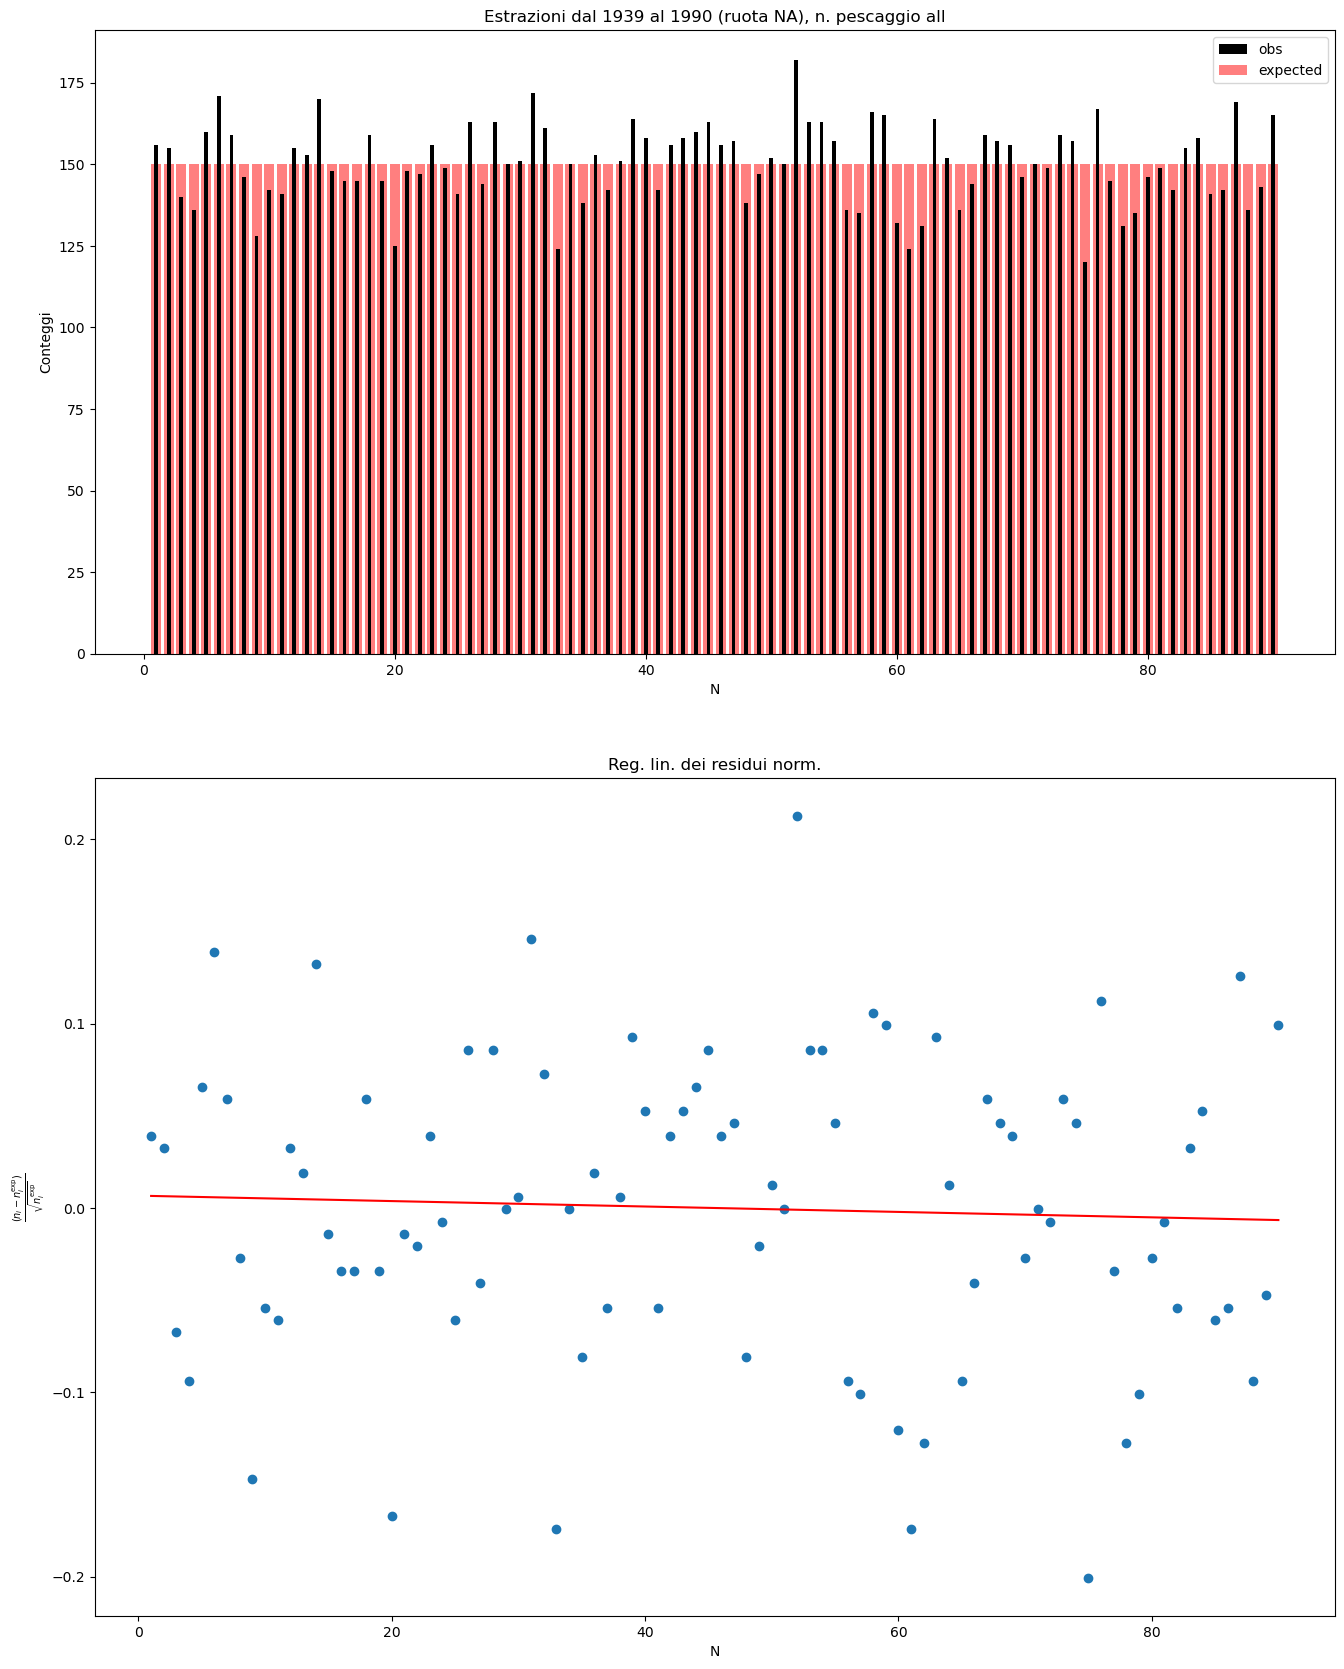

In [35]:
analisi(nome_citta='NA',Y1=1939,Y2=1990)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Napoli tra il 1939 e il 1990 sia uniforme con significatività $\alpha=0.05$. Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri, come prima, data l'entità del valore di $r$ e $p_{\mathrm{slope}}$.

Si è anche effettuato un test consideando solo i conteggi dal 1991, per un primo indizio anche riguardo la scala temporale.

slope :  0.0003118807356367549 intercept : -0.014190573471472333 r (Pearson) :  0.12336465735575104 p (H0 : slope=0):  0.24669615627395733
p value (test del chi quadro): [0.65799038]
p value (test su pendenza): 0.24669615627395733


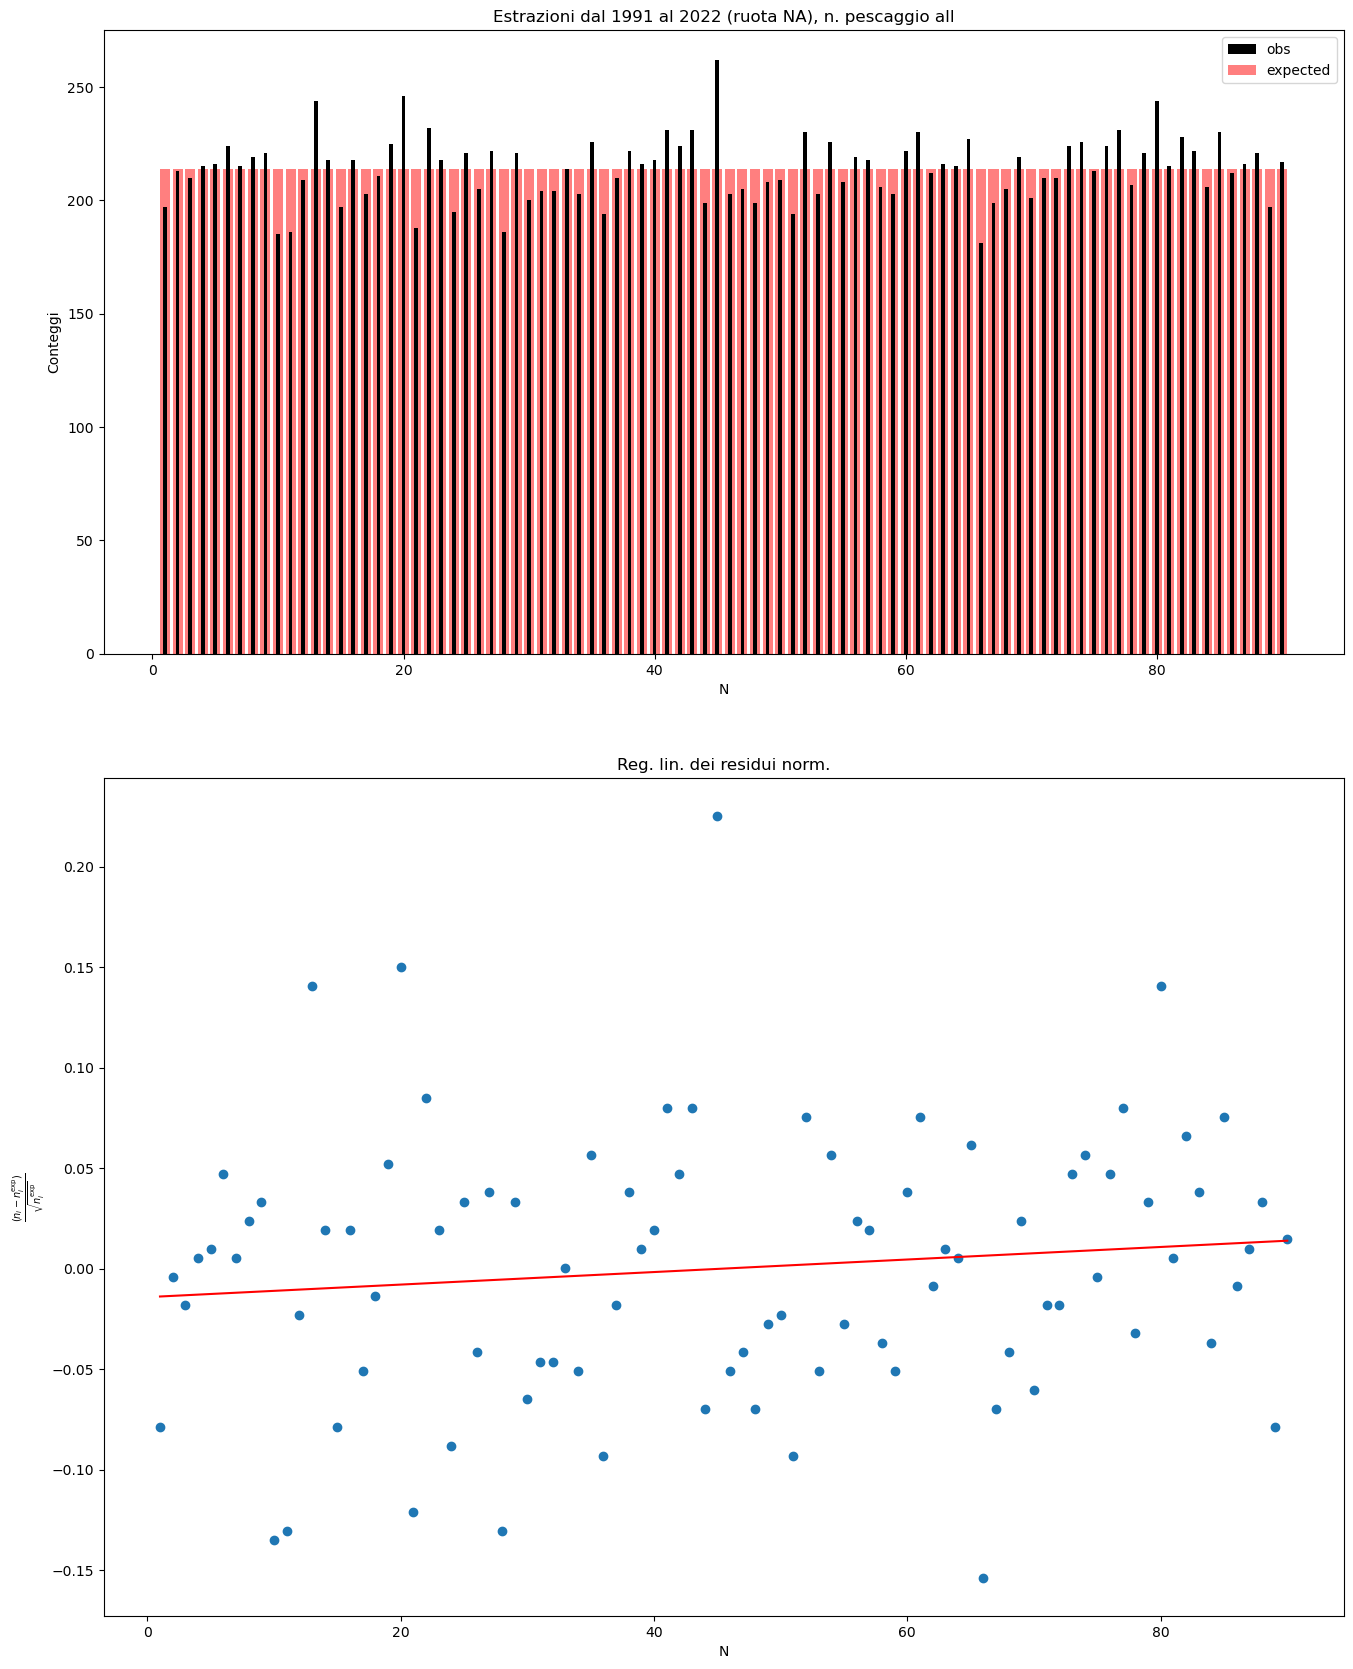

In [36]:
analisi(nome_citta='NA',Y1=1991,Y2=2022)

La precedente analisi è stata condotto sul campione della ruota di NA dal 1991 al 2022. Da questa traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Napoli tra il 1991 e il 2022 sia uniforme con significatività $\alpha=0.05$. Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri, analogamente a prima, ma comunque il $p_{\mathrm{slope}}$ risulta minore dei casi precedenti.

# Ruota di Milano

La procedura effettuata prima si itera per la ruota di Milano.

slope :  0.00014907072129181957 intercept : -0.006782717818777879 r (Pearson) :  0.07540093224462596 p (H0 : slope=0):  0.47998702140973426
p value (test del chi quadro): [0.55684697]
p value (test su pendenza): 0.47998702140973426


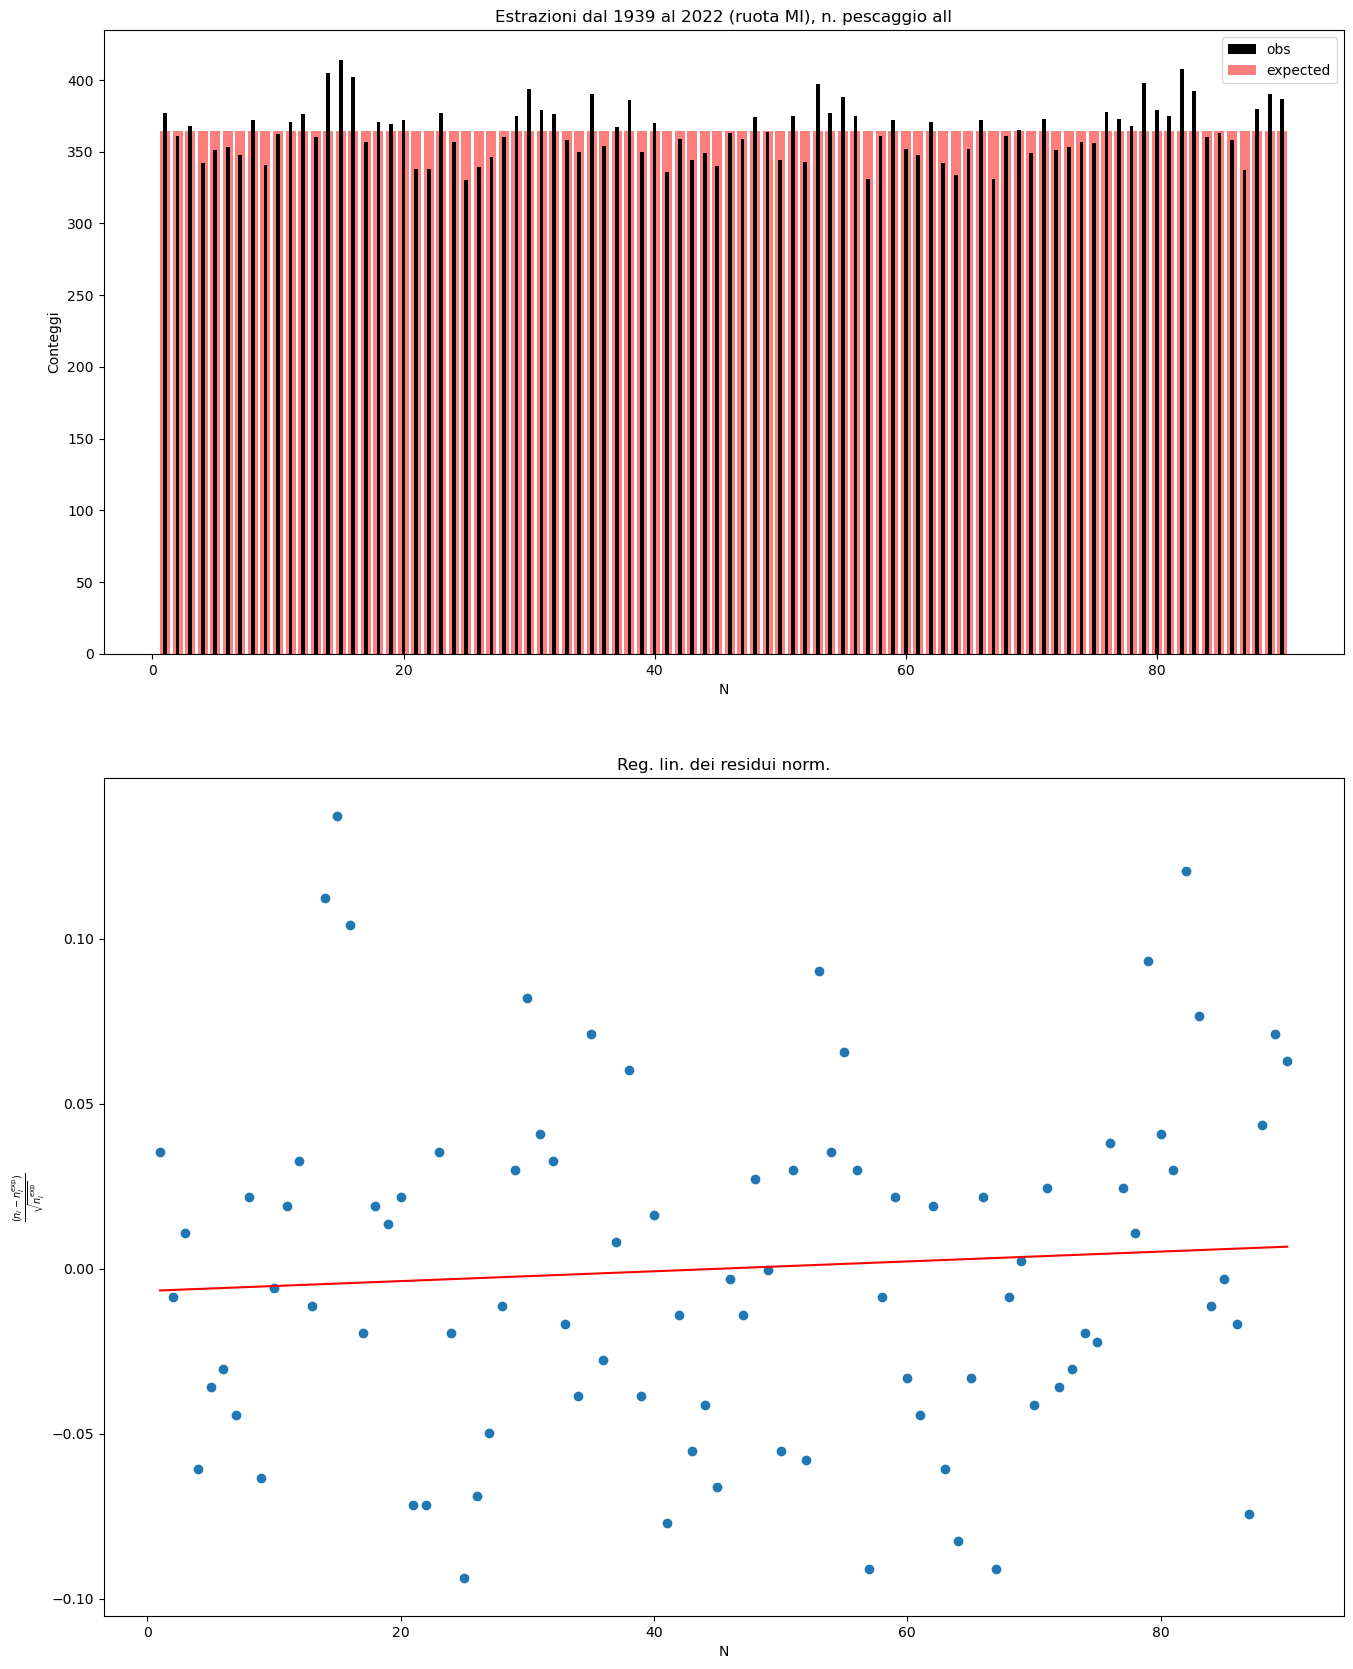

In [37]:
analisi(nome_citta='MI',Y1=1939,Y2=2022)

Dalla precedente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Milano tra il 1939 e il 2022 sia uniforme con significatività $\alpha=0.05$. Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri.

## Ruota di Palermo

slope :  0.00024183122828957962 intercept : -0.011003320887175856 r (Pearson) :  0.12877289650665547 p (H0 : slope=0):  0.22642710479230288
p value (test del chi quadro): [0.79782902]
p value (test su pendenza): 0.22642710479230288


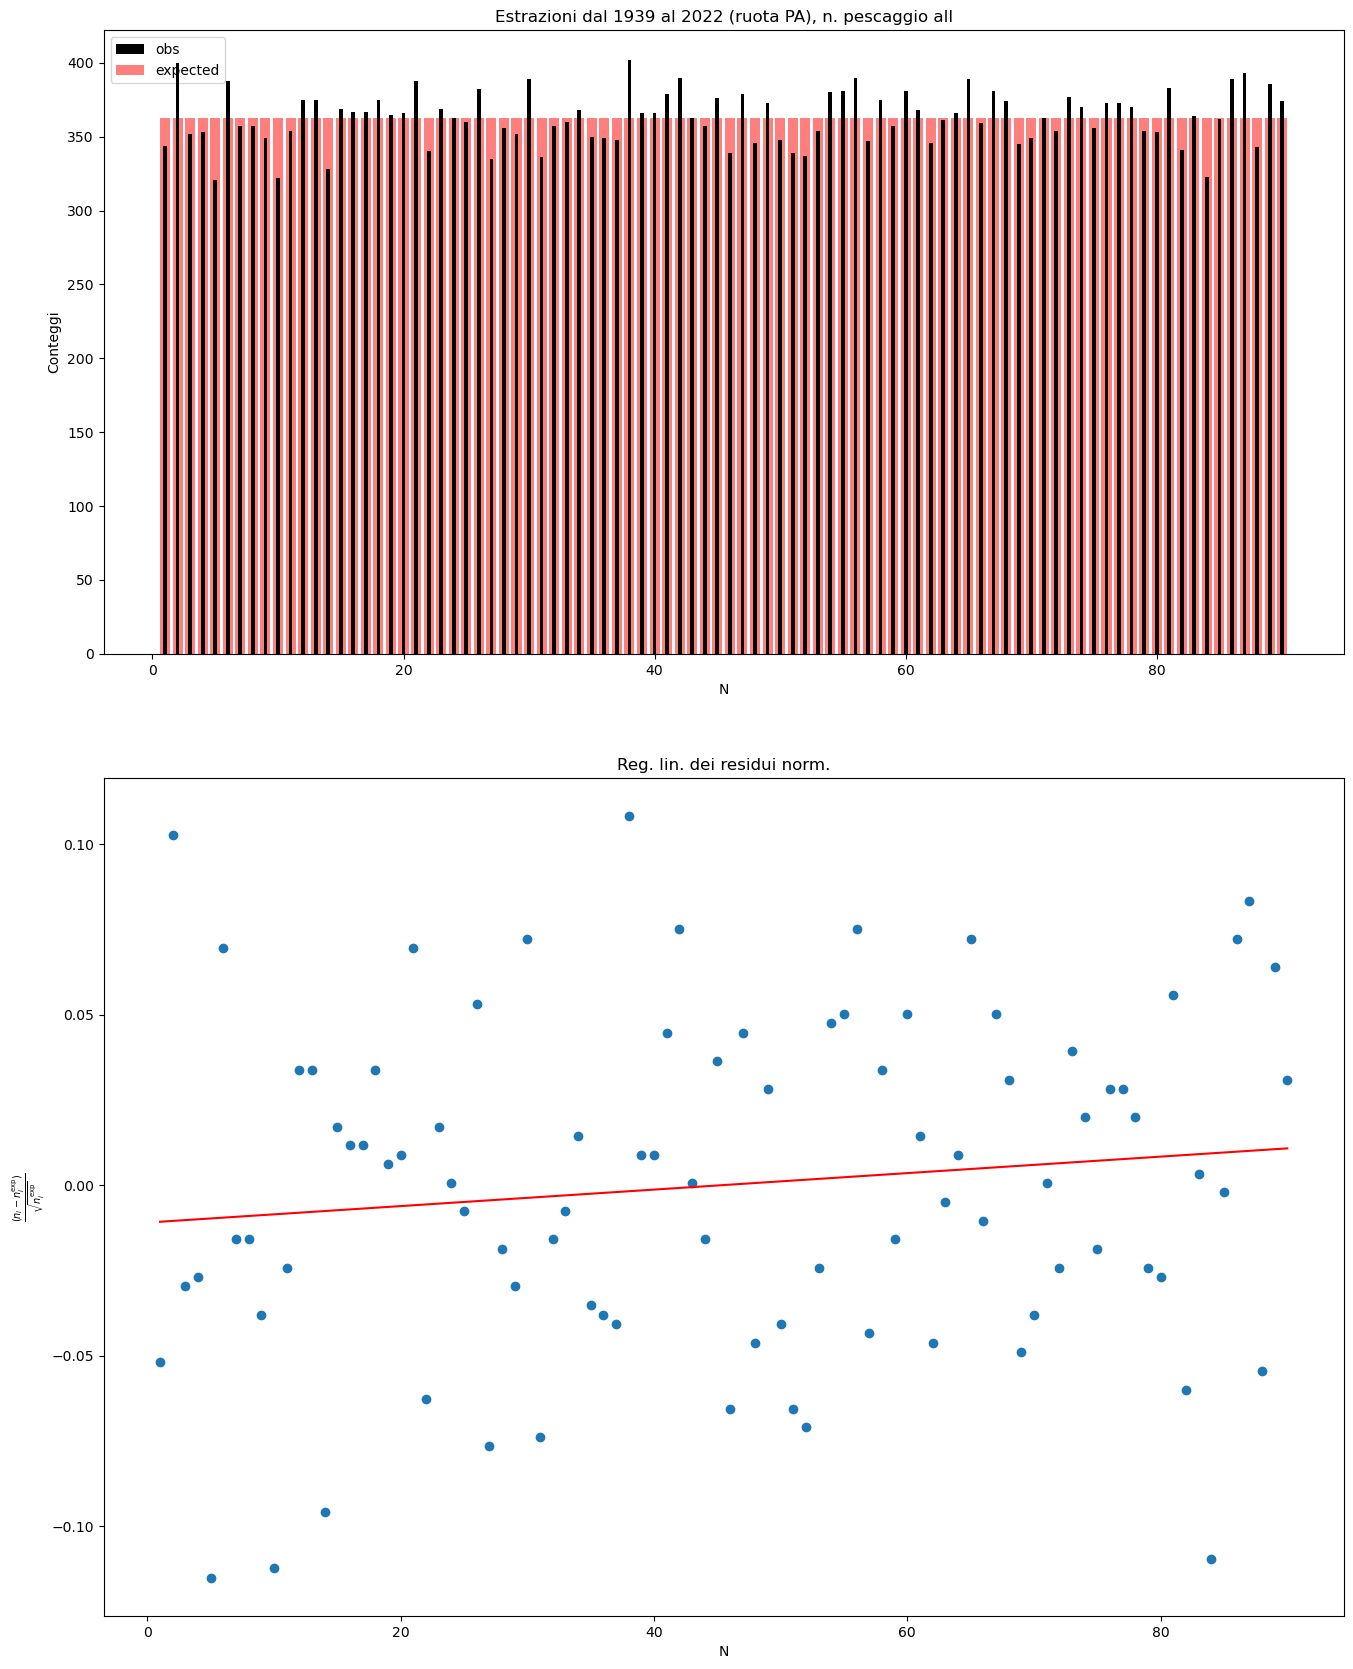

In [38]:
analisi(nome_citta='PA', Y1=1939,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Palermo tra il 1939 e il 2022 sia uniforme con significatività $\alpha=0.05$. Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri.

## Ruora di Torino

slope :  0.00029710175407175033 intercept : -0.01351812981026464 r (Pearson) :  0.13316393416767547 p (H0 : slope=0):  0.21085208409624318
p value (test del chi quadro): [0.0645199]
p value (test su pendenza): 0.21085208409624318


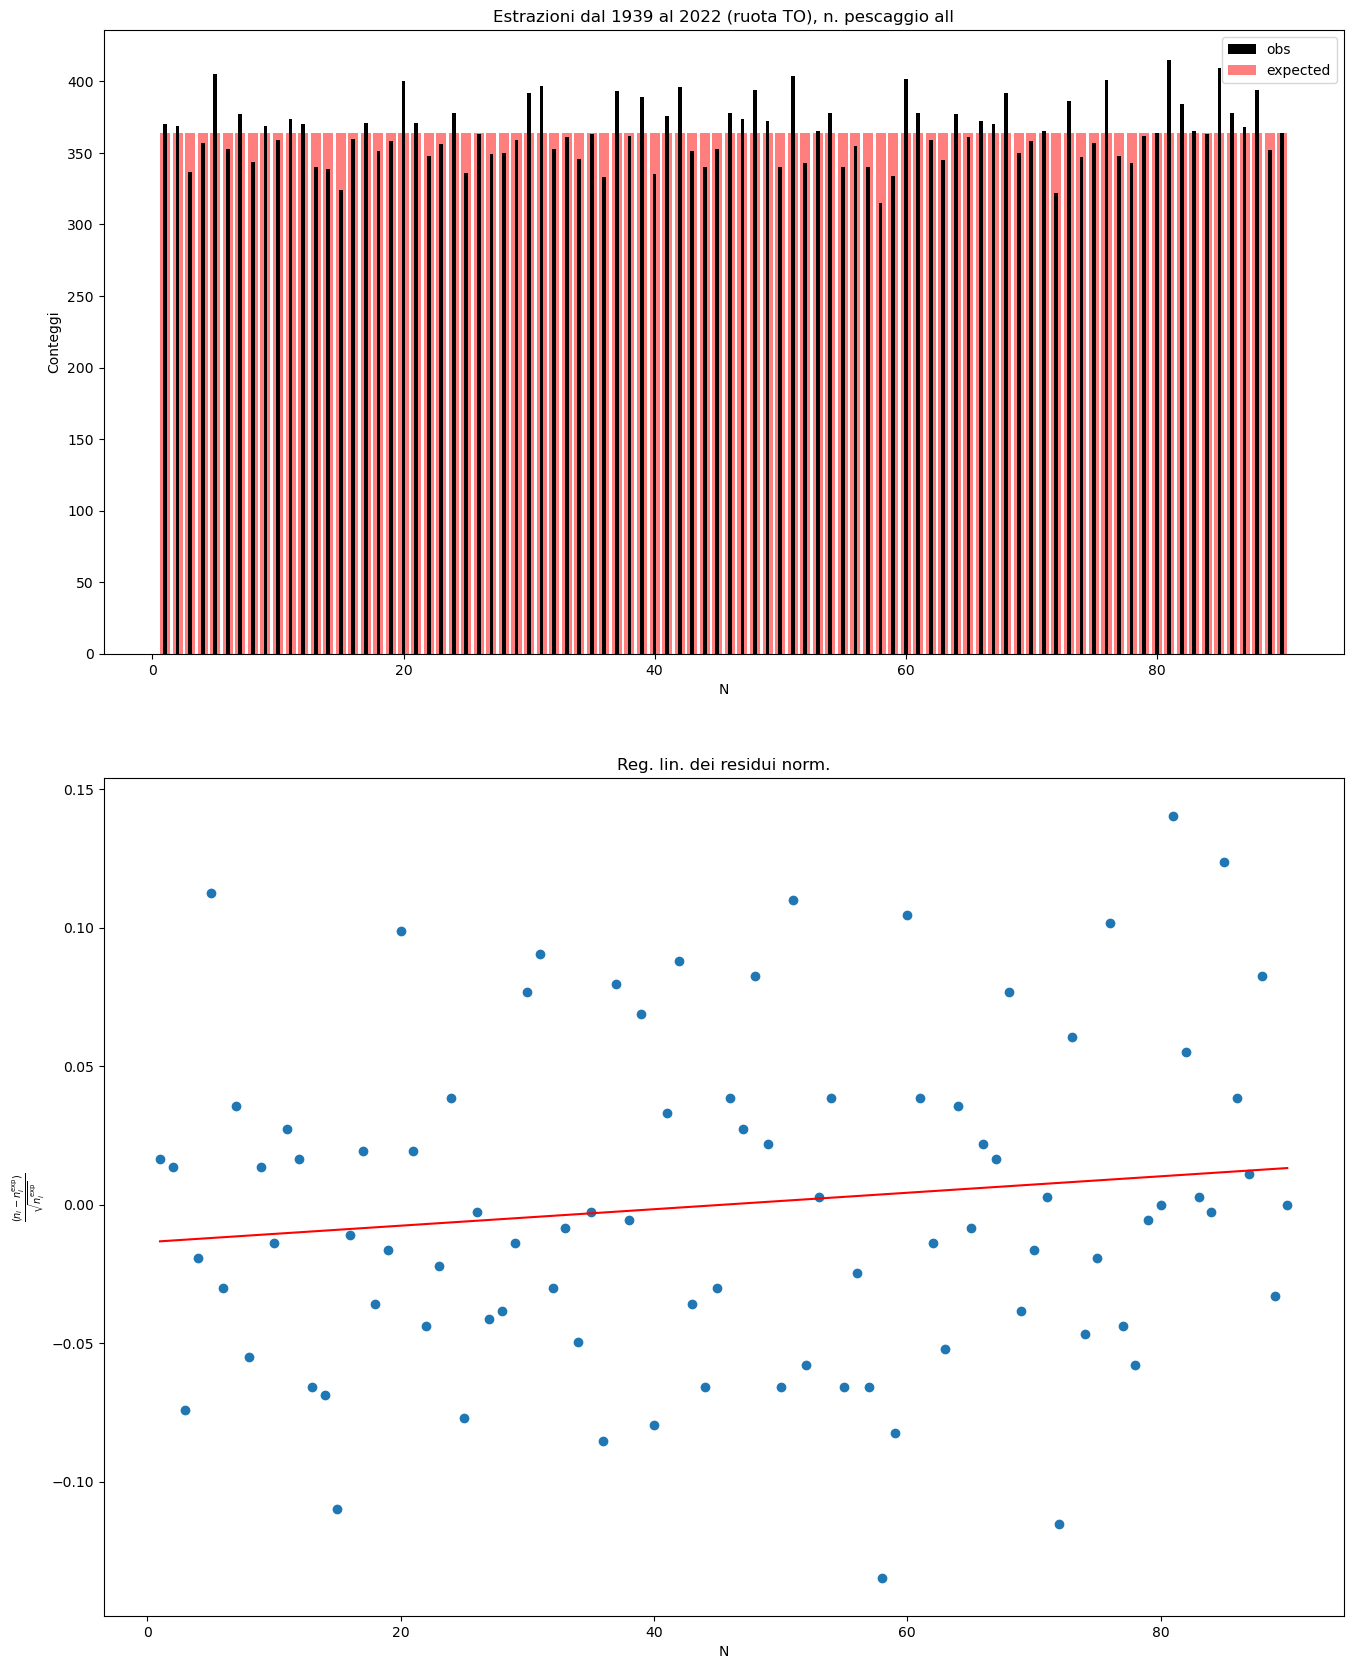

In [39]:
analisi(nome_citta='TO',Y1=1939,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Torino tra il 1939 e il 2022 sia uniforme con significatività $\alpha=0.05$. Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri.

## Ruota di Roma

slope :  0.0004666960324790782 intercept : -0.02123466947779811 r (Pearson) :  0.23371655836812522 p (H0 : slope=0):  0.026620506062506665
p value (test del chi quadro): [0.50395076]
p value (test su pendenza): 0.026620506062506665


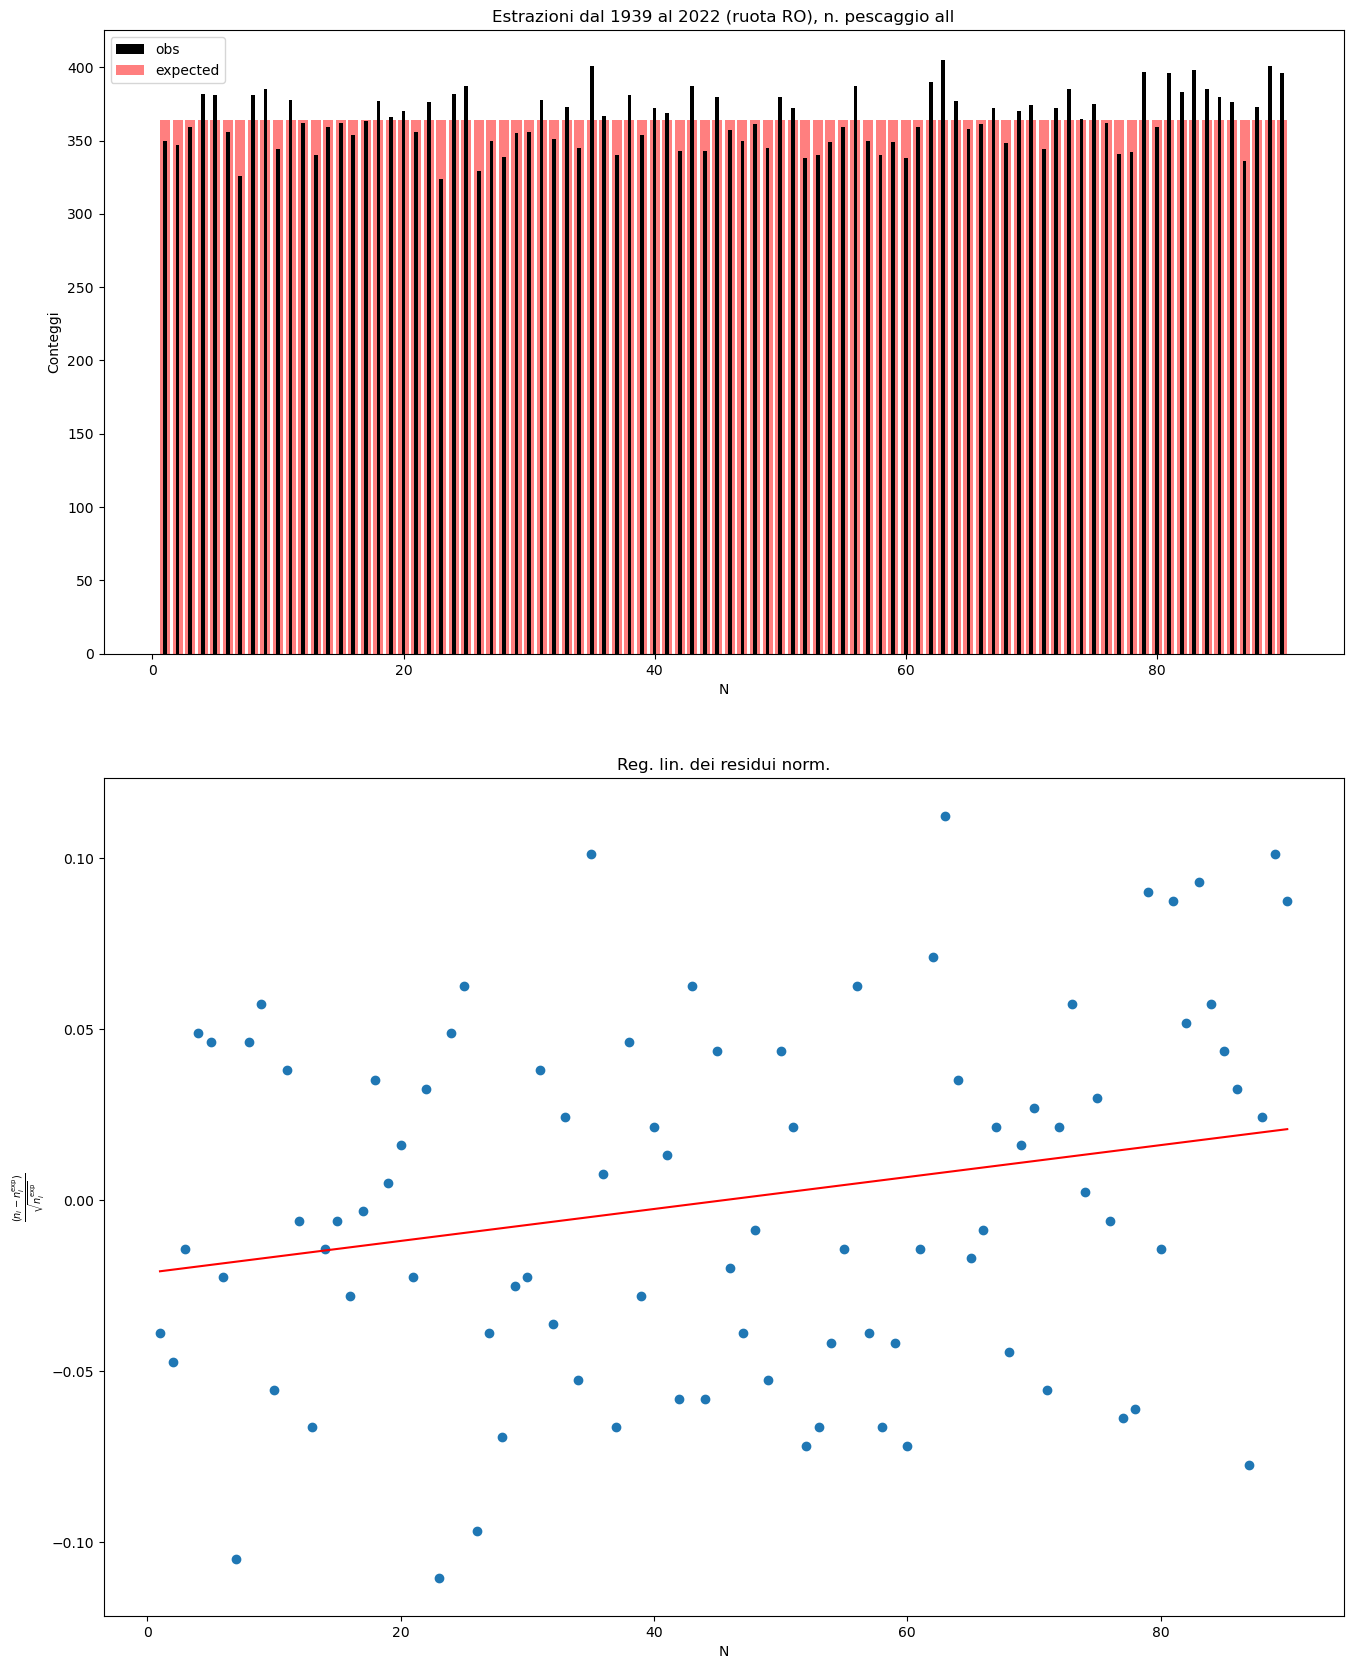

In [40]:
analisi(nome_citta='RO',Y1=1939,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Roma tra il 1939 e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). Si nota inoltre che è possibile avanzare l'ipotesi che ci sia un'effettiva tendenza di alcuni a comparire di più rispetto ad altri, poiché il $p_{\mathrm{slope}}<0.05$, che è la significatività come posta prima. L'effetto è comunque lieve. 

## Ruota di Venezia

1939
slope :  0.0006655508090432468 intercept : -0.030282561811467816 r (Pearson) :  0.3066574495571474 p (H0 : slope=0):  0.00328511160578579
p value (test del chi quadro): [0.12962938]
p value (test su pendenza): 0.00328511160578579


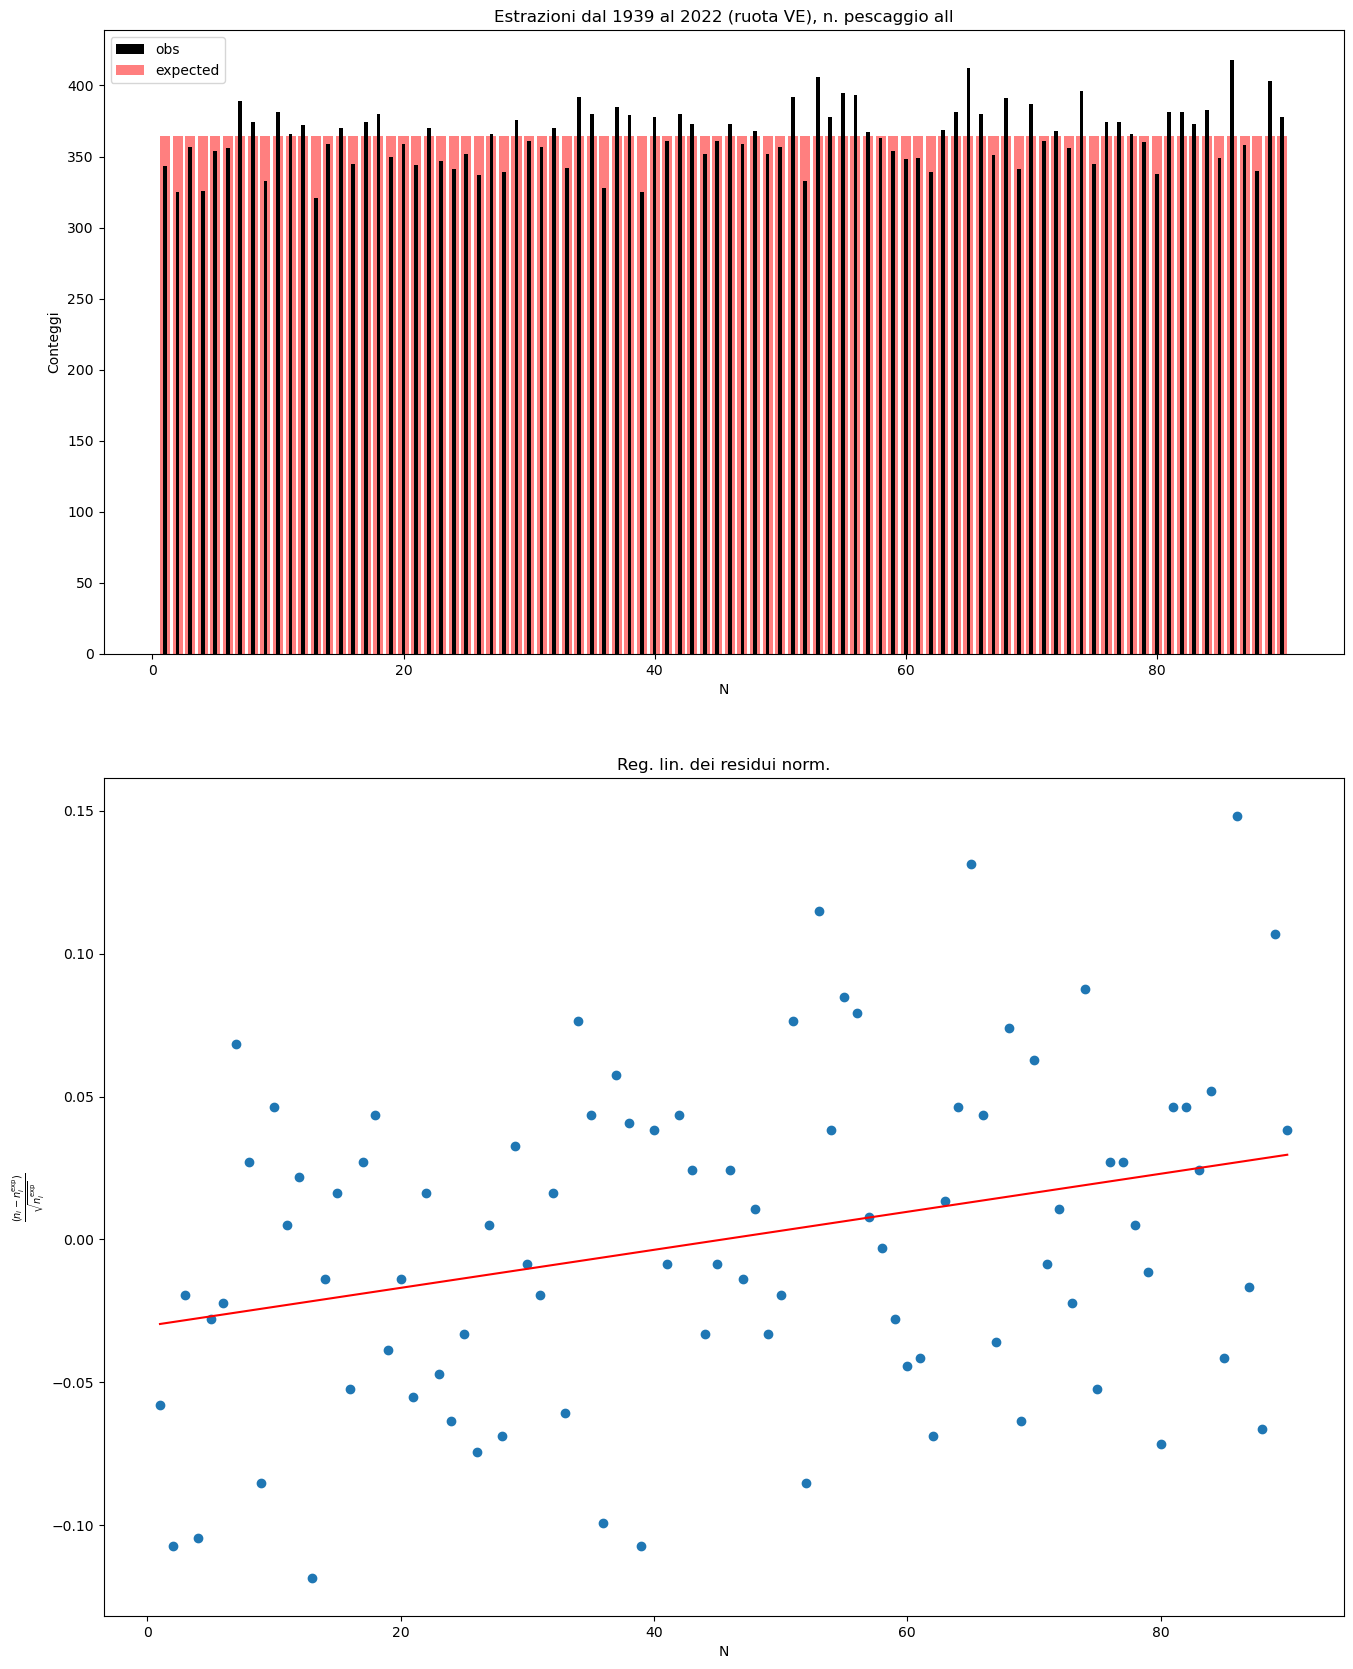

In [44]:
Yv=lotto[lotto.city=='VE']['dt'].dt.year.min()
print(Yv)
analisi(nome_citta='VE',Y1=Yv,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Venezia tra il 1939 e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). Si puè invece escludere con significatività 0.05 che la pendeza della retta sia nulla, quindi c'è possibilità di un'effettiva tendenza di alcuni a comparire di più rispetto ad altri per questa ruota.

## Ruota di Bari

1939
slope :  0.00028263720292979013 intercept : -0.012859992733305467 r (Pearson) :  0.12984542829857285 p (H0 : slope=0):  0.22255040556692235
p value (test del chi quadro): [0.12067549]
p value (test su pendenza): 0.22255040556692235


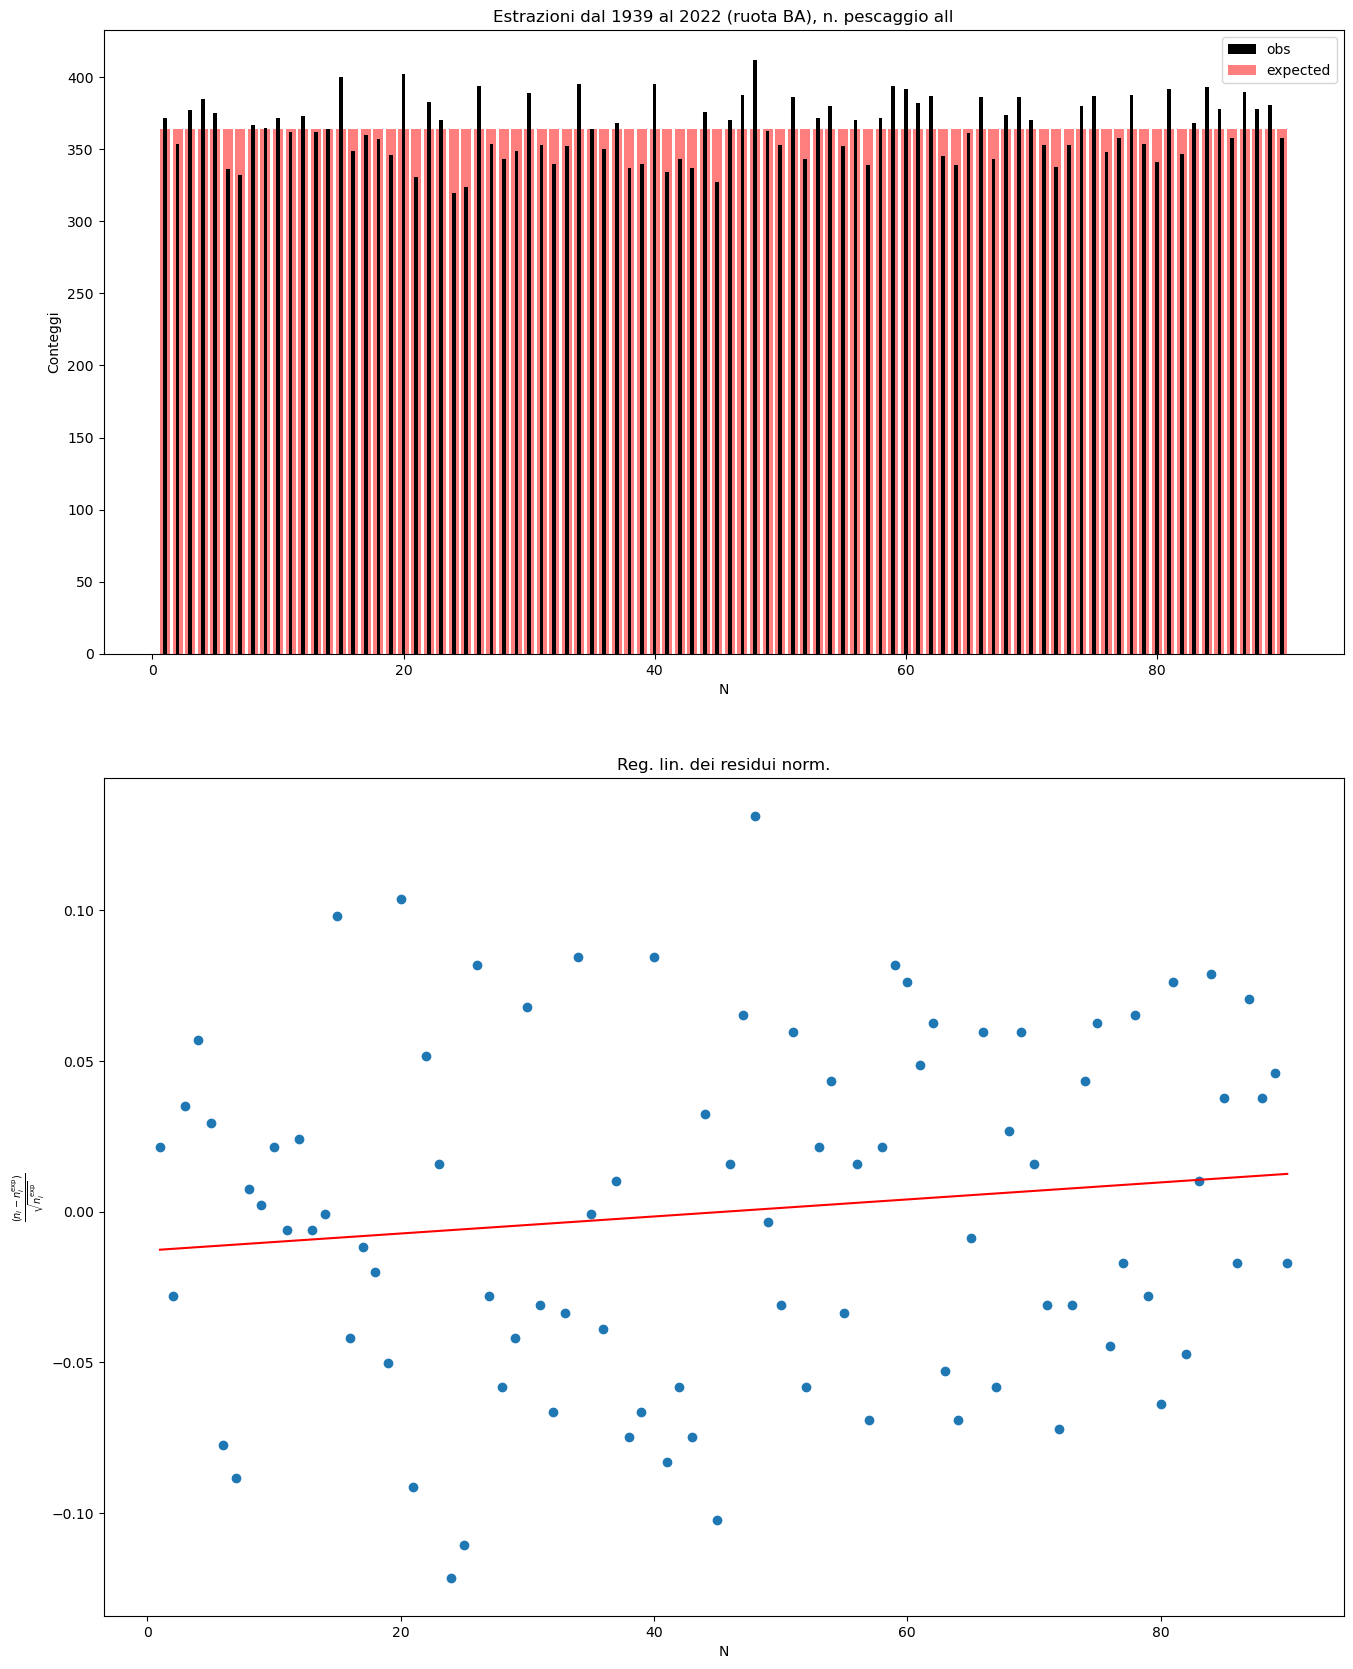

In [43]:
Yb=lotto[lotto.city=='BA']['dt'].dt.year.min()
print(Yb)
analisi('BA',Y1=Yb,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Bari tra il 1939 e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri. La retta di regressione non ha pendenza nulla con $\alpha=0.05$

## Ruota di Firenze

slope :  0.00011142460199782612 intercept : -0.005069819390901194 r (Pearson) :  0.056119081229489276 p (H0 : slope=0):  0.5993297322815865
p value (test del chi quadro): [0.53647335]
p value (test su pendenza): 0.5993297322815865


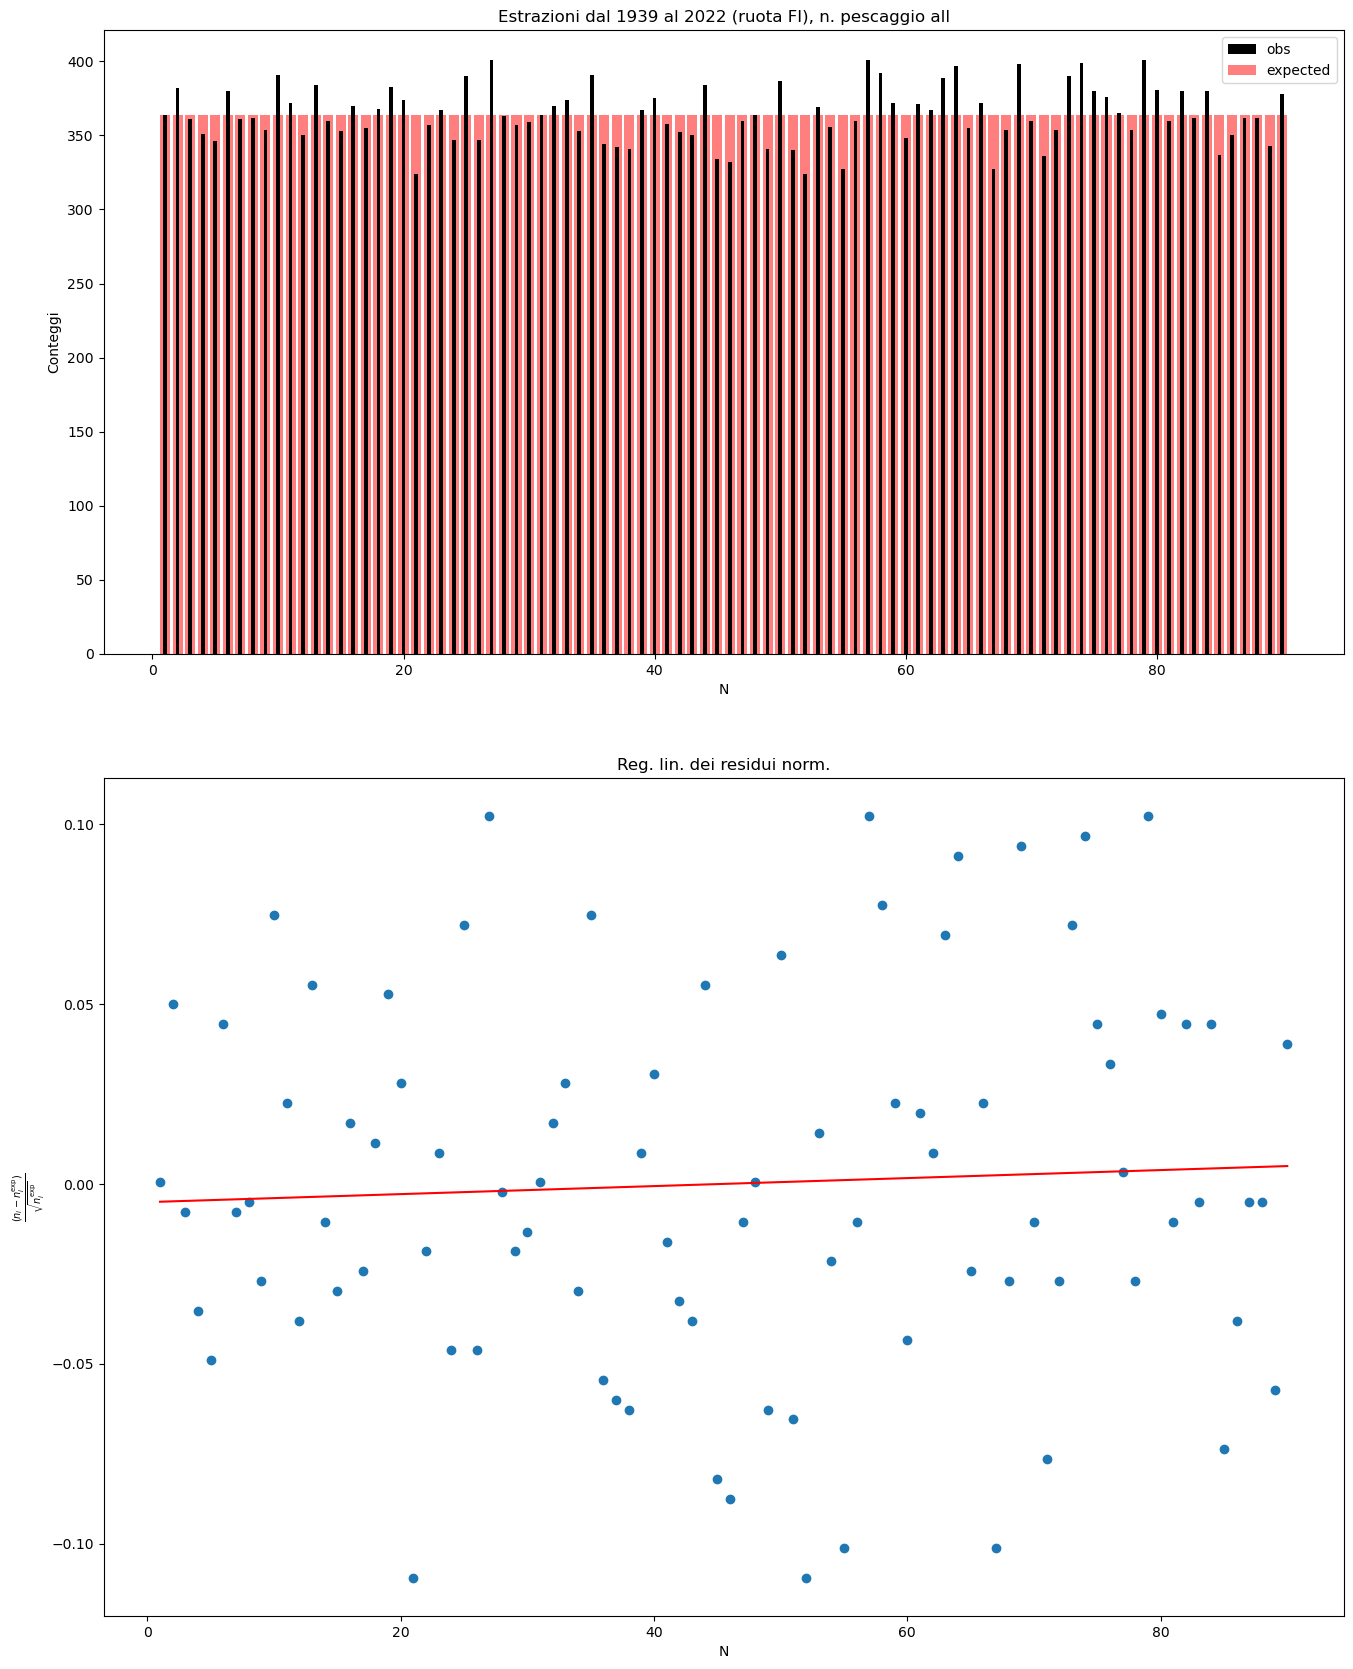

In [45]:
Yf=lotto[lotto.city=='FI']['dt'].dt.year.min()
analisi(nome_citta='FI', Y1=Yf,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Firenze tra l'anno di introduzione e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri

## Ruota di Cagliari

1939
slope :  0.0010334029987818531 intercept : -0.04701983644457442 r (Pearson) :  0.48738140490822945 p (H0 : slope=0):  1.1061224838339086e-06
p value (test del chi quadro): [0.24132037]
p value (test su pendenza): 1.1061224838339086e-06


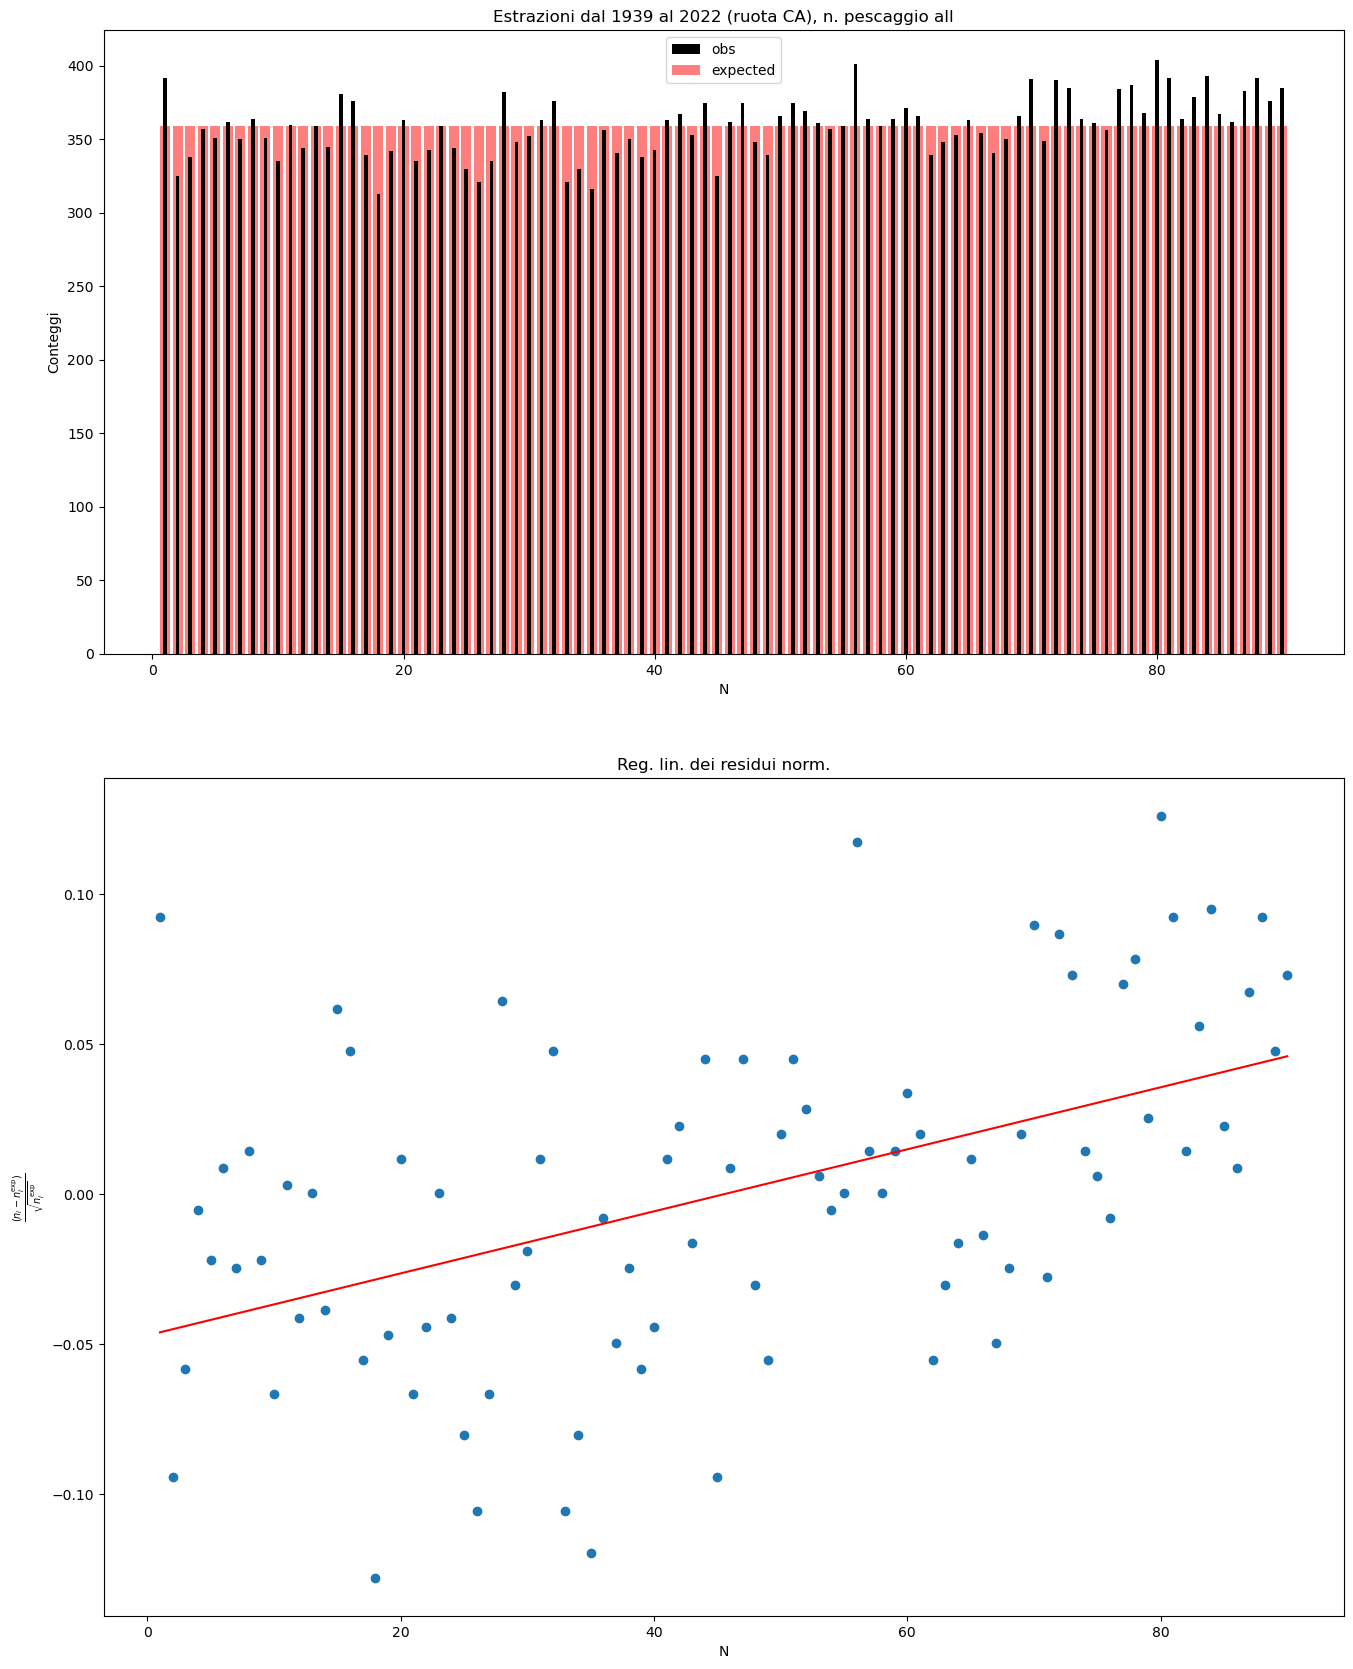

In [47]:
Yc=lotto[lotto.city=='FI']['dt'].dt.year.min()
print(Yc)
analisi(nome_citta='CA',Y1=Yc,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Cagliari tra l'anno di introduzione e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). Si nota inoltre che c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri, o meglio la pendenza della retta di regressione ha valore nullo con significatività $0.05$.

## Ruota di Genoa

1939
slope :  0.00022438187805575325 intercept : -0.010209375451536842 r (Pearson) :  0.12498042360878198 p (H0 : slope=0):  0.24051395321613903
p value (test del chi quadro): [0.9188628]
p value (test su pendenza): 0.24051395321613903


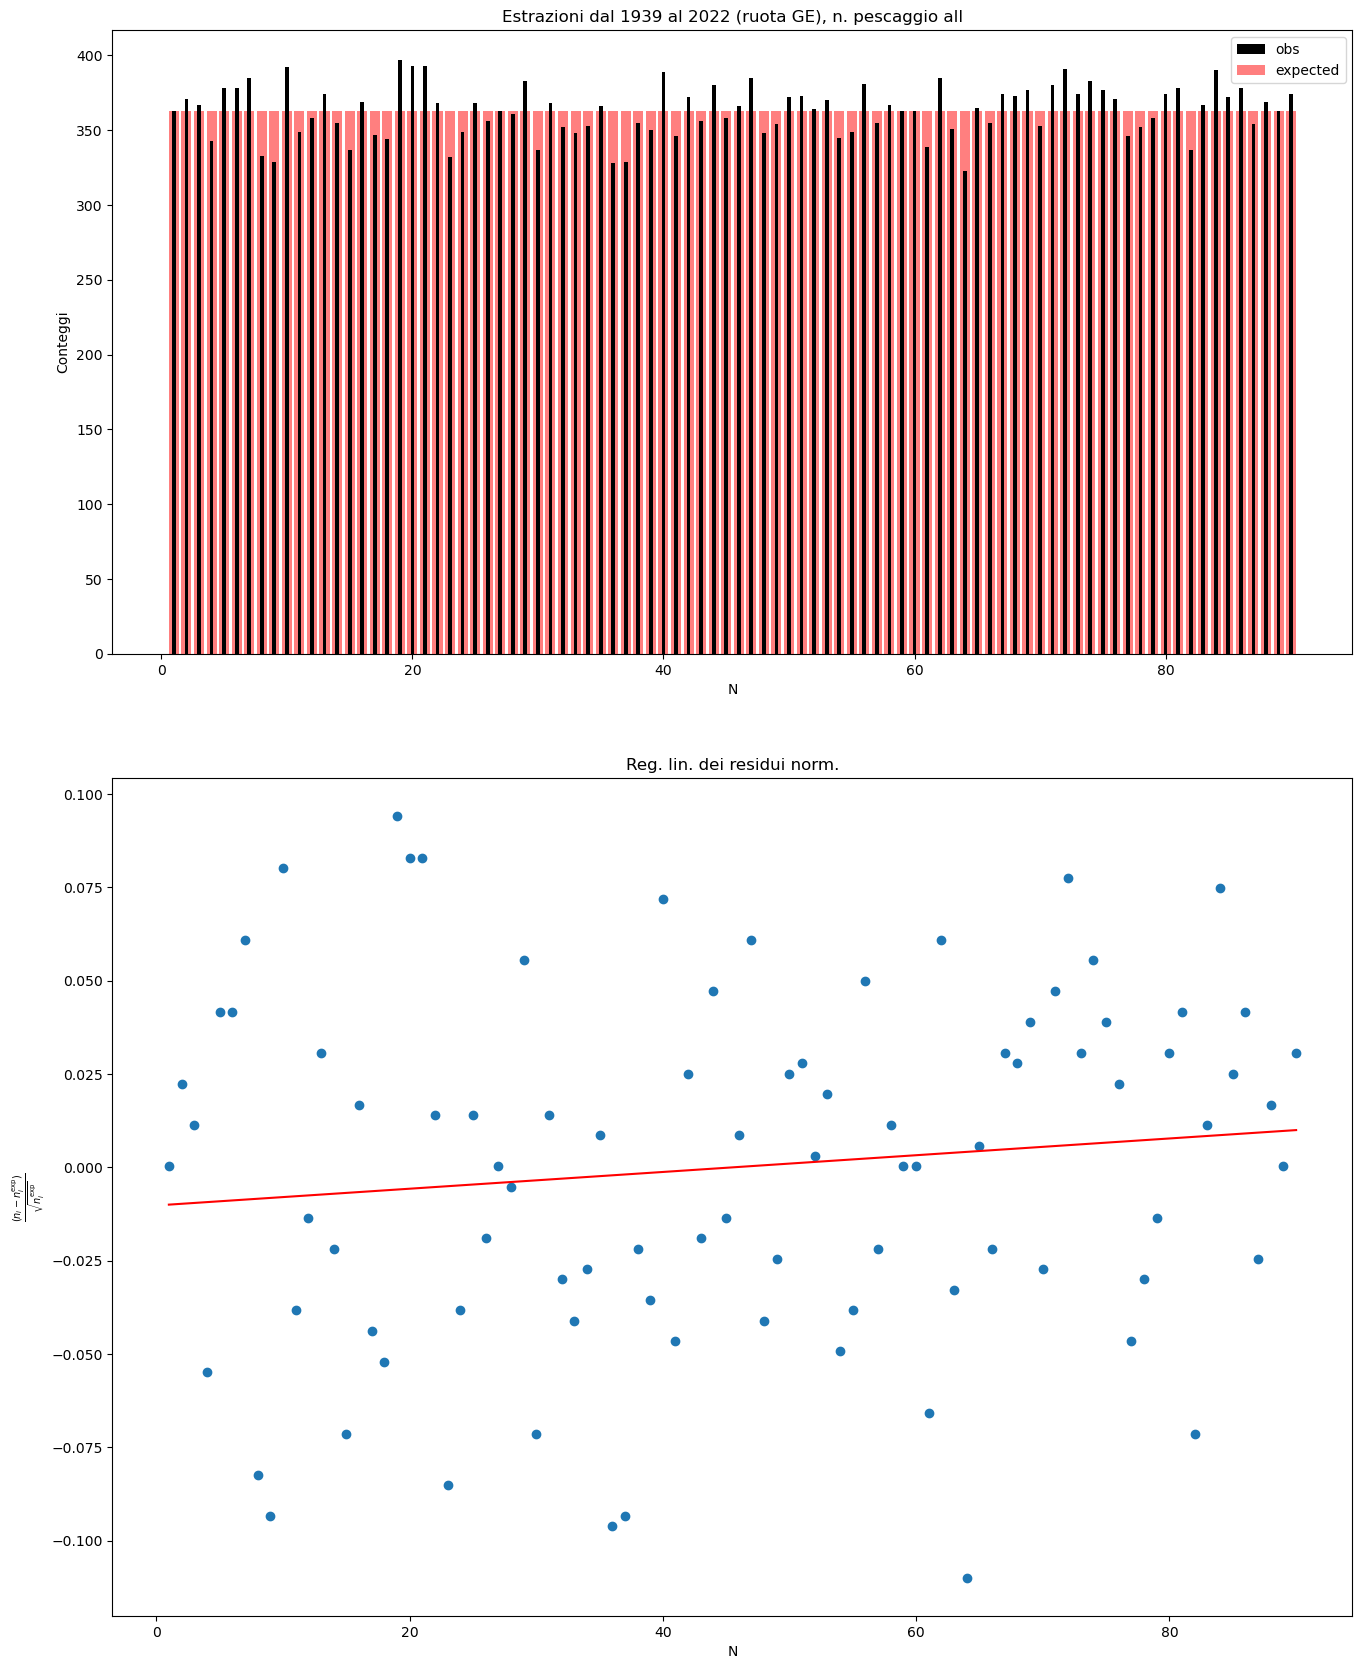

In [48]:
Yg=lotto[lotto.city=='GE']['dt'].dt.year.min()
print(Yg)
analisi(nome_citta='GE',Y1=Yc,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni a Genoa tra l'anno di introduzione e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). Si nota inoltre che non c'è un'effettiva tendenza di alcuni a comparire di più rispetto ad altri, o meglio non si può scartare l'ipotesi che la pendenza sia nulla con signif. 0.05.

## Ruota Nazionale

slope :  -0.0004834554411628015 intercept : 0.021997222572907406 r (Pearson) :  -0.16018612335264004 p (H0 : slope=0):  0.13151008083574328
p value (test del chi quadro): [0.68547936]
p value (test su pendenza): 0.13151008083574328


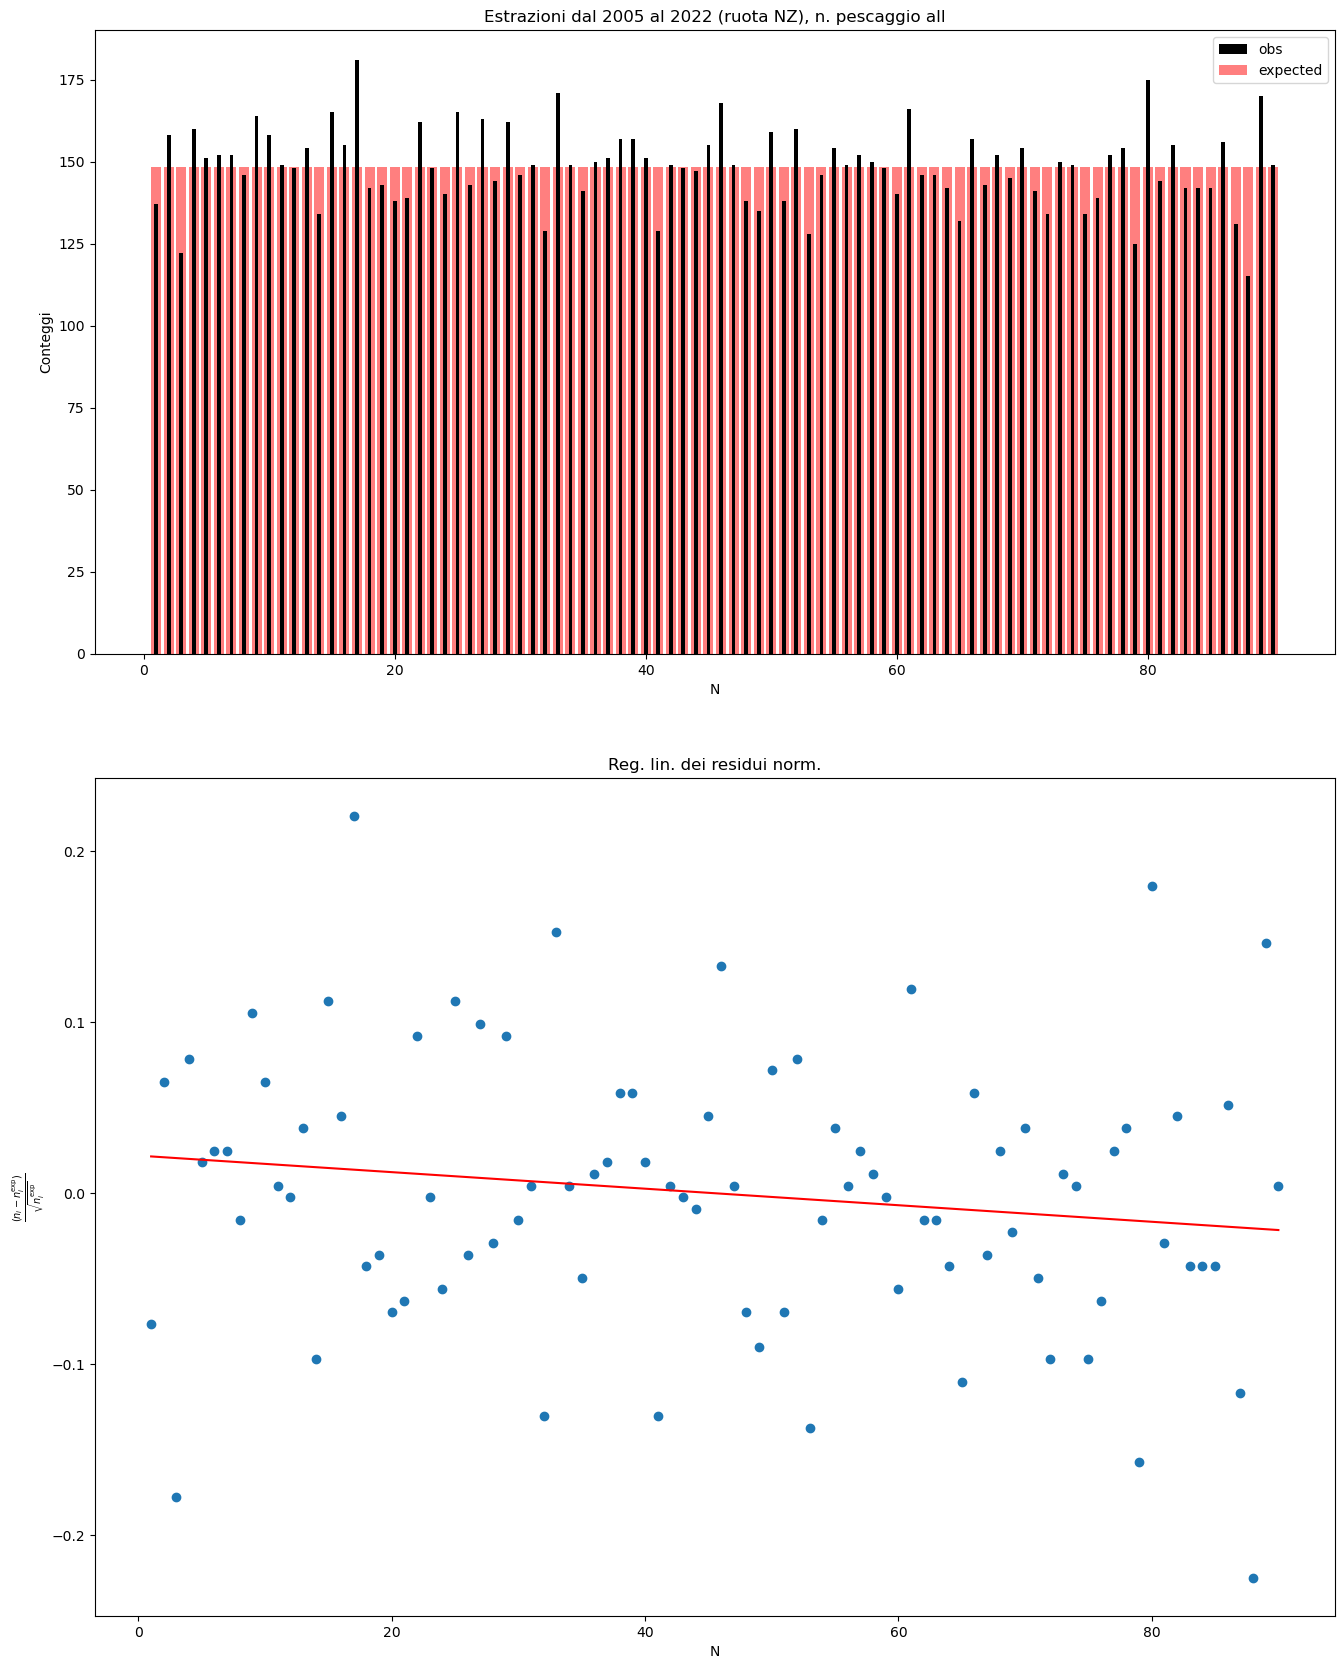

In [49]:
YN=lotto[lotto.city=='NZ']['dt'].dt.year.min()
analisi(nome_citta='NZ',Y1=YN,Y2=2022)

Dalla seguente analisi traiamo le seguenti conclusioni: non è possibile escludere l'ipotesi che la distribuzione delle estrazioni della ruoata nazionale tra l'anno di introduzione e il 2022 sia uniforme con significatività $\alpha=0.05$ ($\chi^2$). I risultati sulla pendenza sono analoghi a prima.

Da tutte le considerazioni precedenti si ricava che il test del $\chi^2$ fornisce sempre lo stesso esito, impedendo di scartare l'ipotesi nulla con la sua significatività. Il test della pendenza, invece, pare più sensibile alla tendeza osservata e in qualche caso permette di concludere che, entro la significatività, la pendenza non sia nulla. In ogni caso, tali effetti risultano di entità tale da non permettere il passaggio di entrambi i test. Si prosegue con l'analisi.

## Analisi sul numero di estrazioni
La seguente analisi è stata condotta sui singoli pescaggi dei numeri dall'urna. Quello che si è voluto analizzare è la distribuzione dei numeri al n-esimo pescaggio. Quel che ci si aspetta è che anche queste ultime seguano una distribuzione uniforme. Per corroborare quest'ipotesi si è applicato di nuovo il test del $\chi^2$ alle varie distribuzioni.

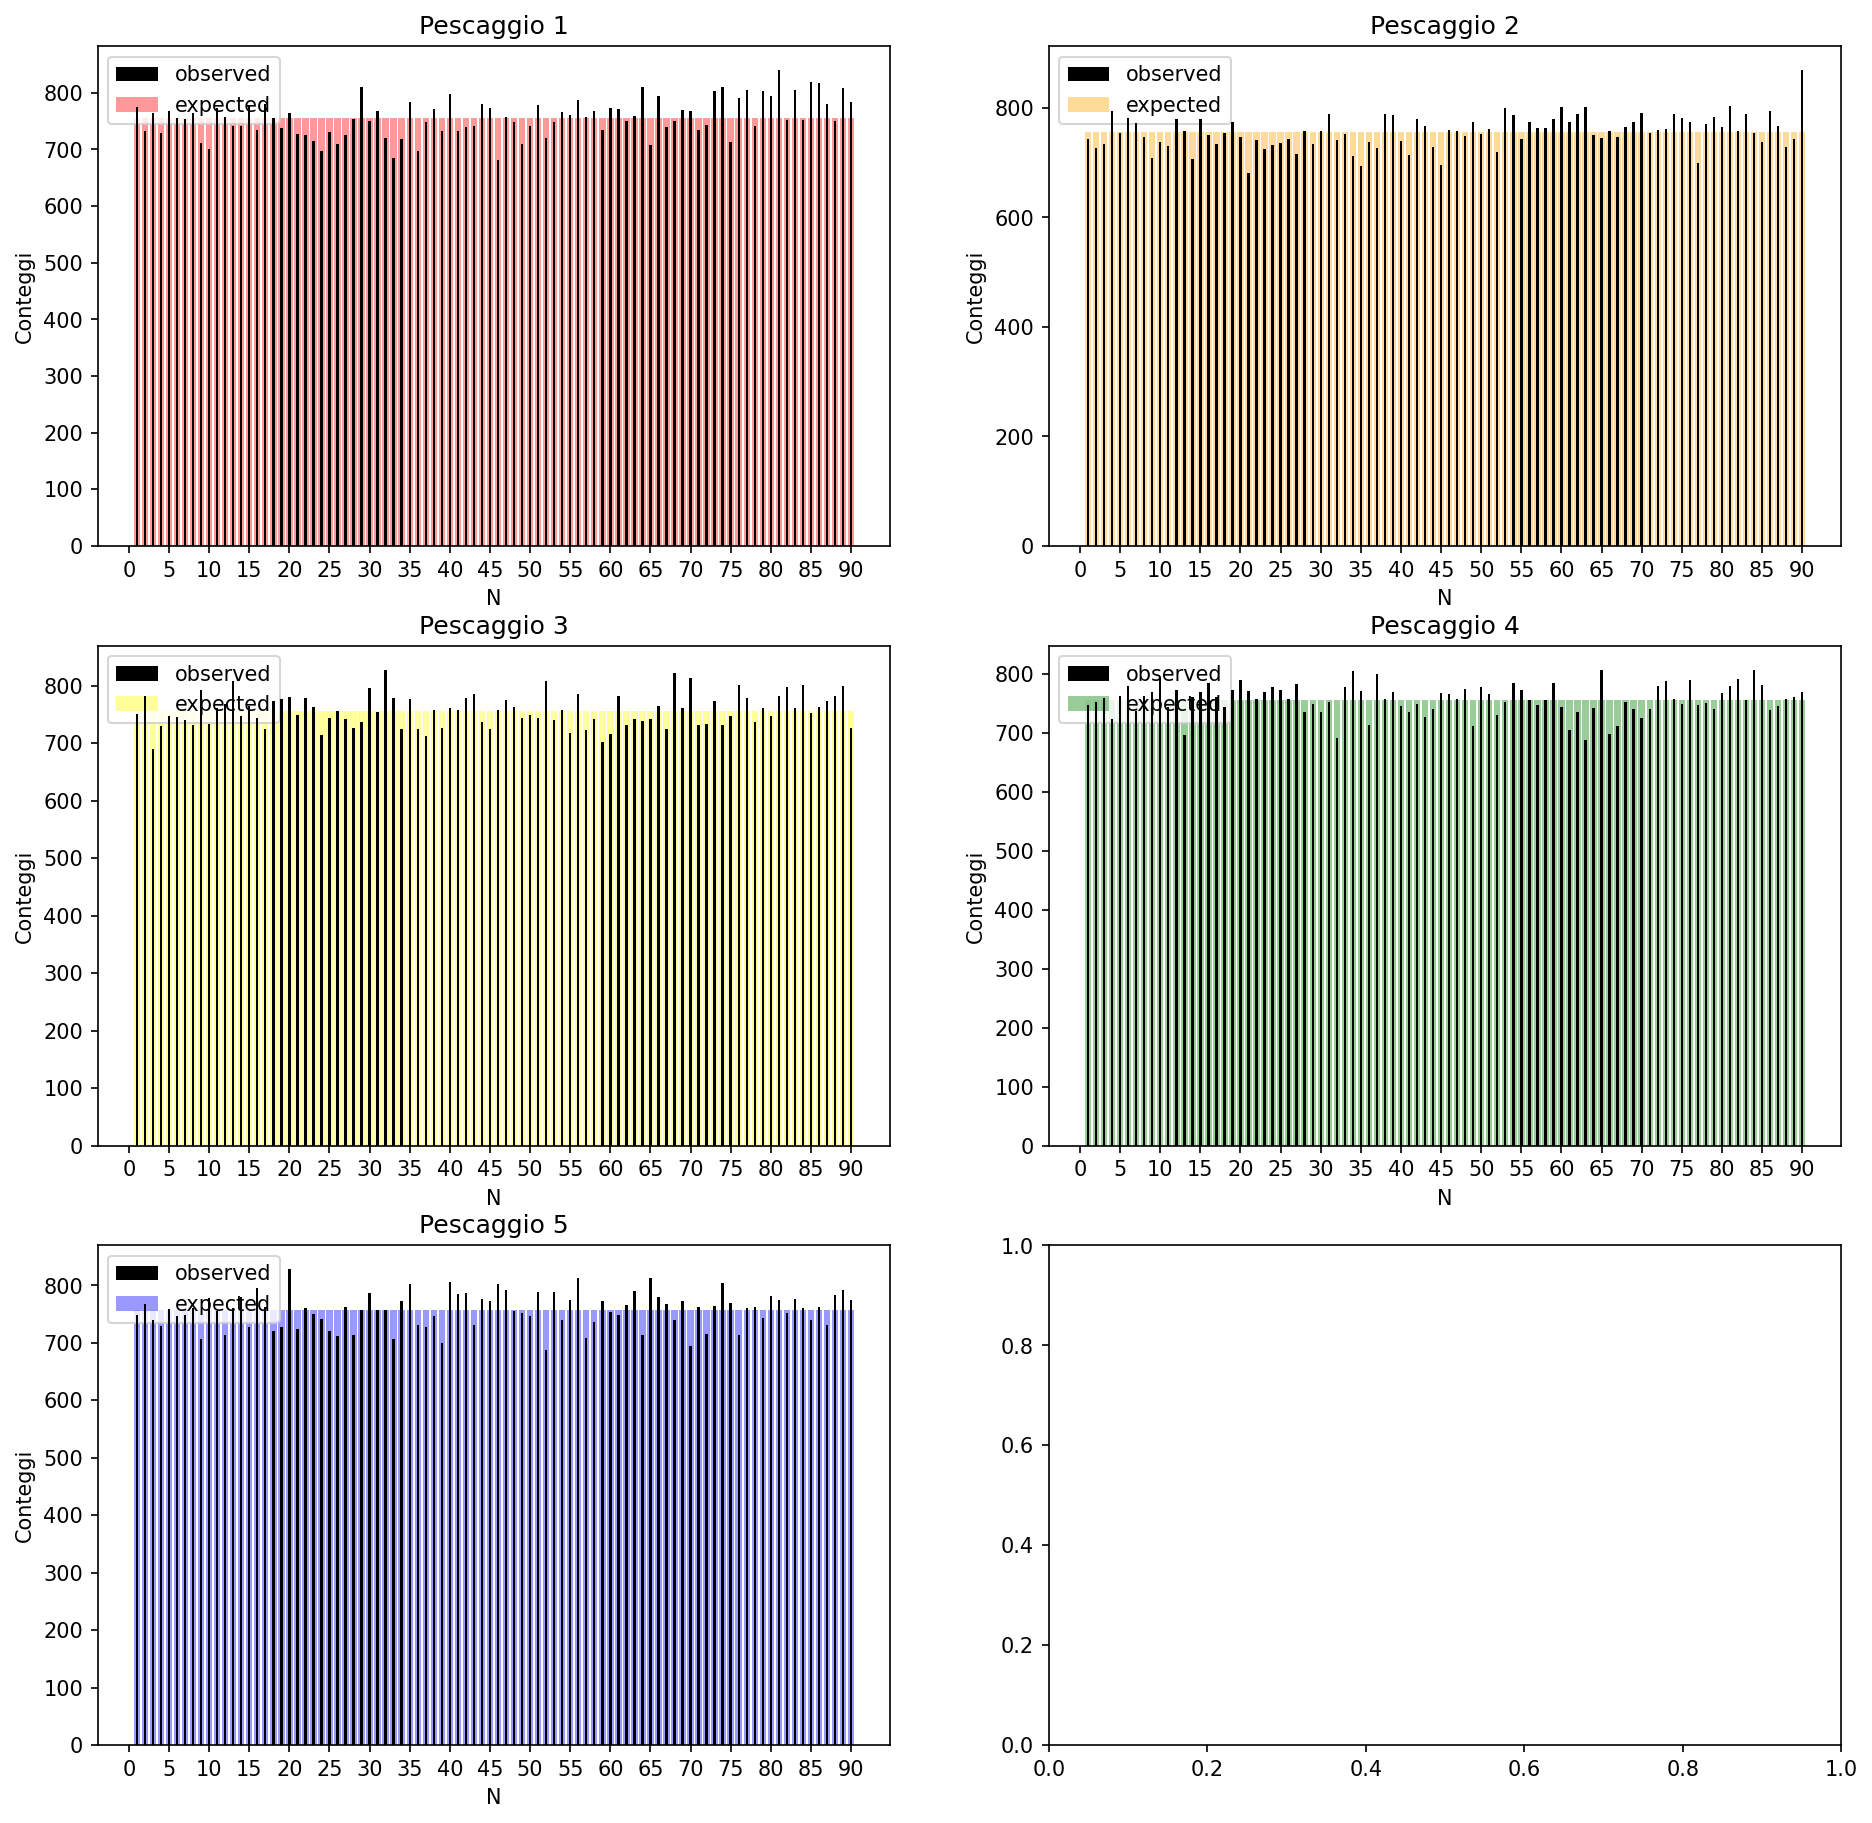

dof= 89


,chi2,p value,Z
1,127.235014,0.004891,2.583457
2,103.217031,0.143892,1.062997
3,91.892983,0.395738,0.264394
4,76.996121,0.814102,-0.893114
5,102.971086,0.147715,1.046284


In [50]:
fig,ax=plt.subplots(3,2,figsize=(15,15),dpi=150)
ax1,ax2,ax3,ax4,ax5,ax6=ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]
CHI2=[]
for numb,color,AX in zip(['1','2','3','4','5'],['r','orange','yellow','green','blue'],[ax1,ax2,ax3,ax4,ax5]):
    vals=plot_bar(city_name='all',Y1=1939,Y2=2022,numb=numb,show=False)
    test1,test2=chi2_test(vals)
    exp,obs,idxs=test2['exp'].values,test2['obs'].values,vals.index
    chi2_i=test1['chi2'].values
    AX.bar(idxs,obs,color='black',width=0.3,zorder=100,label='observed')
    AX.bar(idxs,exp,color=color,alpha=0.4,label='expected')
    AX.legend()
    AX.set_title(r'Pescaggio '+numb)
    AX.set_xlabel(r'N')
    AX.set_ylabel('Conteggi')
    AX.set_xticks(range(0,91,5))
    CHI2.append(chi2_i)
plt.show()
dof=90-1
print('dof=',dof)
table_chi2=pd.DataFrame(CHI2, columns=['chi2'],index=range(1,6))
table_chi2['p value']=stats.chi2.sf(np.array(CHI2),dof)
table_chi2['Z']=-stats.norm.ppf(table_chi2['p value'])
table_chi2

Quello che si osserva è che si può escludere che l'estrazione di un dato numero al primo pescaggio segue una distribuzione uniforme con una significatività di $\alpha=0.05$. Invece il test fornisce risultato opposto per i casi successivi. Si riportano di seguito i residui normalizzati, con relativa regressione lineare. Ciò restituisce un indice della tendenza dei numeri più alti a essere estratti con maggiore frequenza. 

slope :  0.018728031685722603 intercept : -0.8521254417003779 r (Pearson) :  0.40919954817154125 p (H0 : slope=0):  6.213360032243312e-05


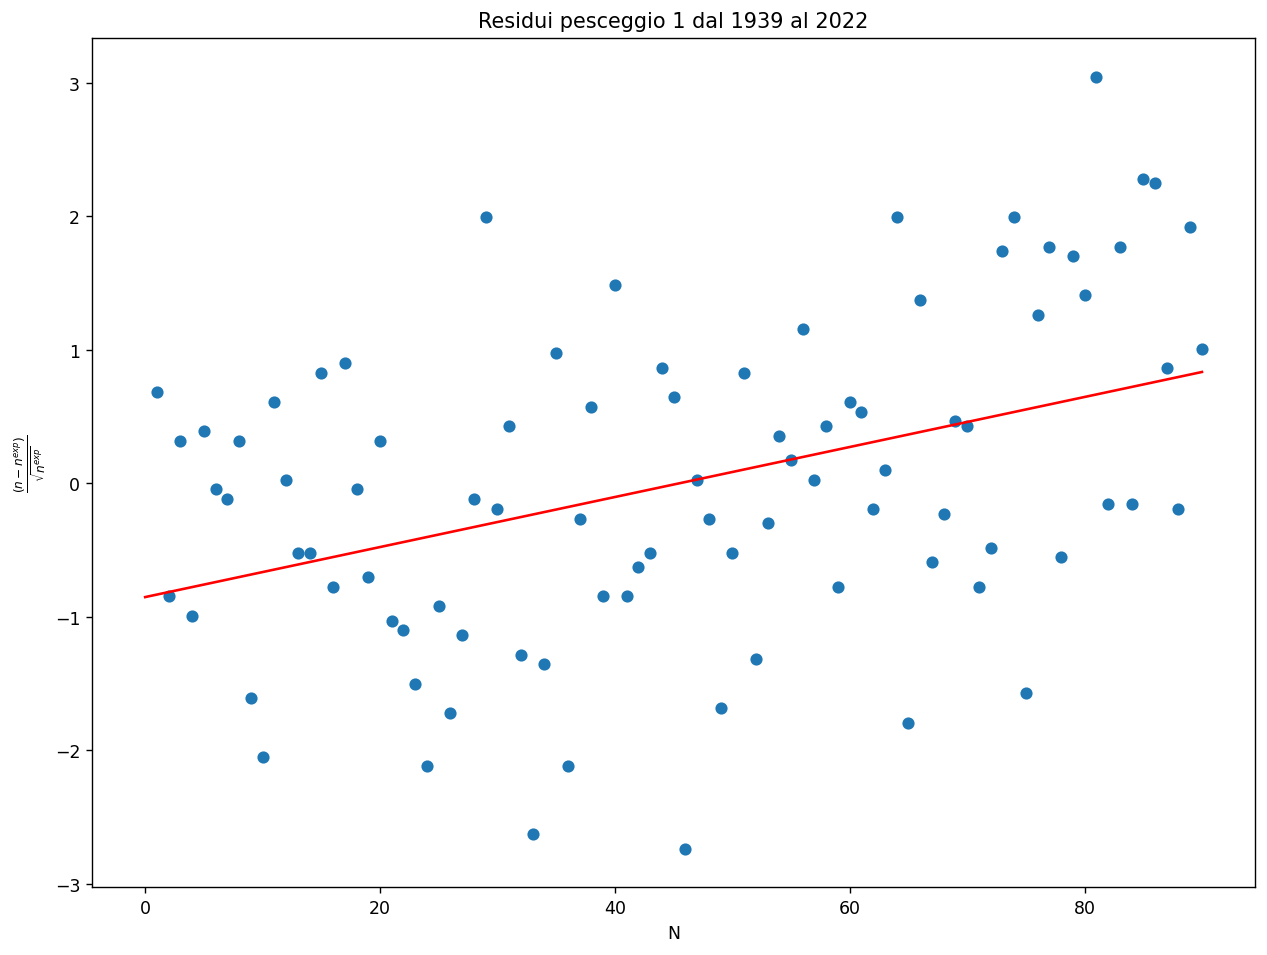

In [51]:
vals=plot_bar(city_name='all',Y1=1939,Y2=2022,numb='1',show=False)
test1,test2=chi2_test(vals)
residuesnorm=test2.res/np.sqrt(test2.exp)
a,b,r,p=linreg(residuesnorm)
plt.figure(figsize=(12,9),dpi=125)
plt.scatter(residuesnorm.index,residuesnorm)
plt.plot([0,90],[0*a+b,a*90+b],color='red')
plt.title('Residui pesceggio 1 dal 1939 al 2022')
plt.xlabel('N')
plt.ylabel(r'$\frac{(n-n^{exp})}{\sqrt{n^{exp}}}$')
plt.show()

I risultati a cui si perviene tramite le precedenti analisi conducono al sospetto che la discrepanza osservata sia dovuta a non idealità del metodo di estrazione (e.g. in un dispositivo di estrazione meccanico, se le palline vengono inserite in ordine crescente nella ruota e poi mescolati, è ragionevole pensare che la probabilità che i numeri inseriti alla fine abbiano maggiore probabilità di essere pescati, con l'avanzare delle estrazioni l'effetto si ridurrebbe per via del mescolamento). Si procede ora con un'analisi condotta su sotto-campioni estratti suddividendo la scala temporale.

## Analisi temporale
Per valutare se nel tempo il comportamento del campione vari, si procede come di seguito: si effettuano test ripetuti su campioni corrispondenti agli esiti di estrazione al primo pescaggio (che dalle analisi precedenti sembra più sensibile alla discrepanza osservata) in un lasso di tempo stabilito. Nello specifico, si considera un arco temporale $[Y1,Y2]$; per ciascun anno $Y$ compreso tra gli estremi, si effettua un test del $\chi^2$ e una stima del valore del coefficiente $r$ come prima sul campione di estrazioni da $Y$ a $Y+20\,\mathrm{anni}$; i risultati vengono poi esibiti graficamente.

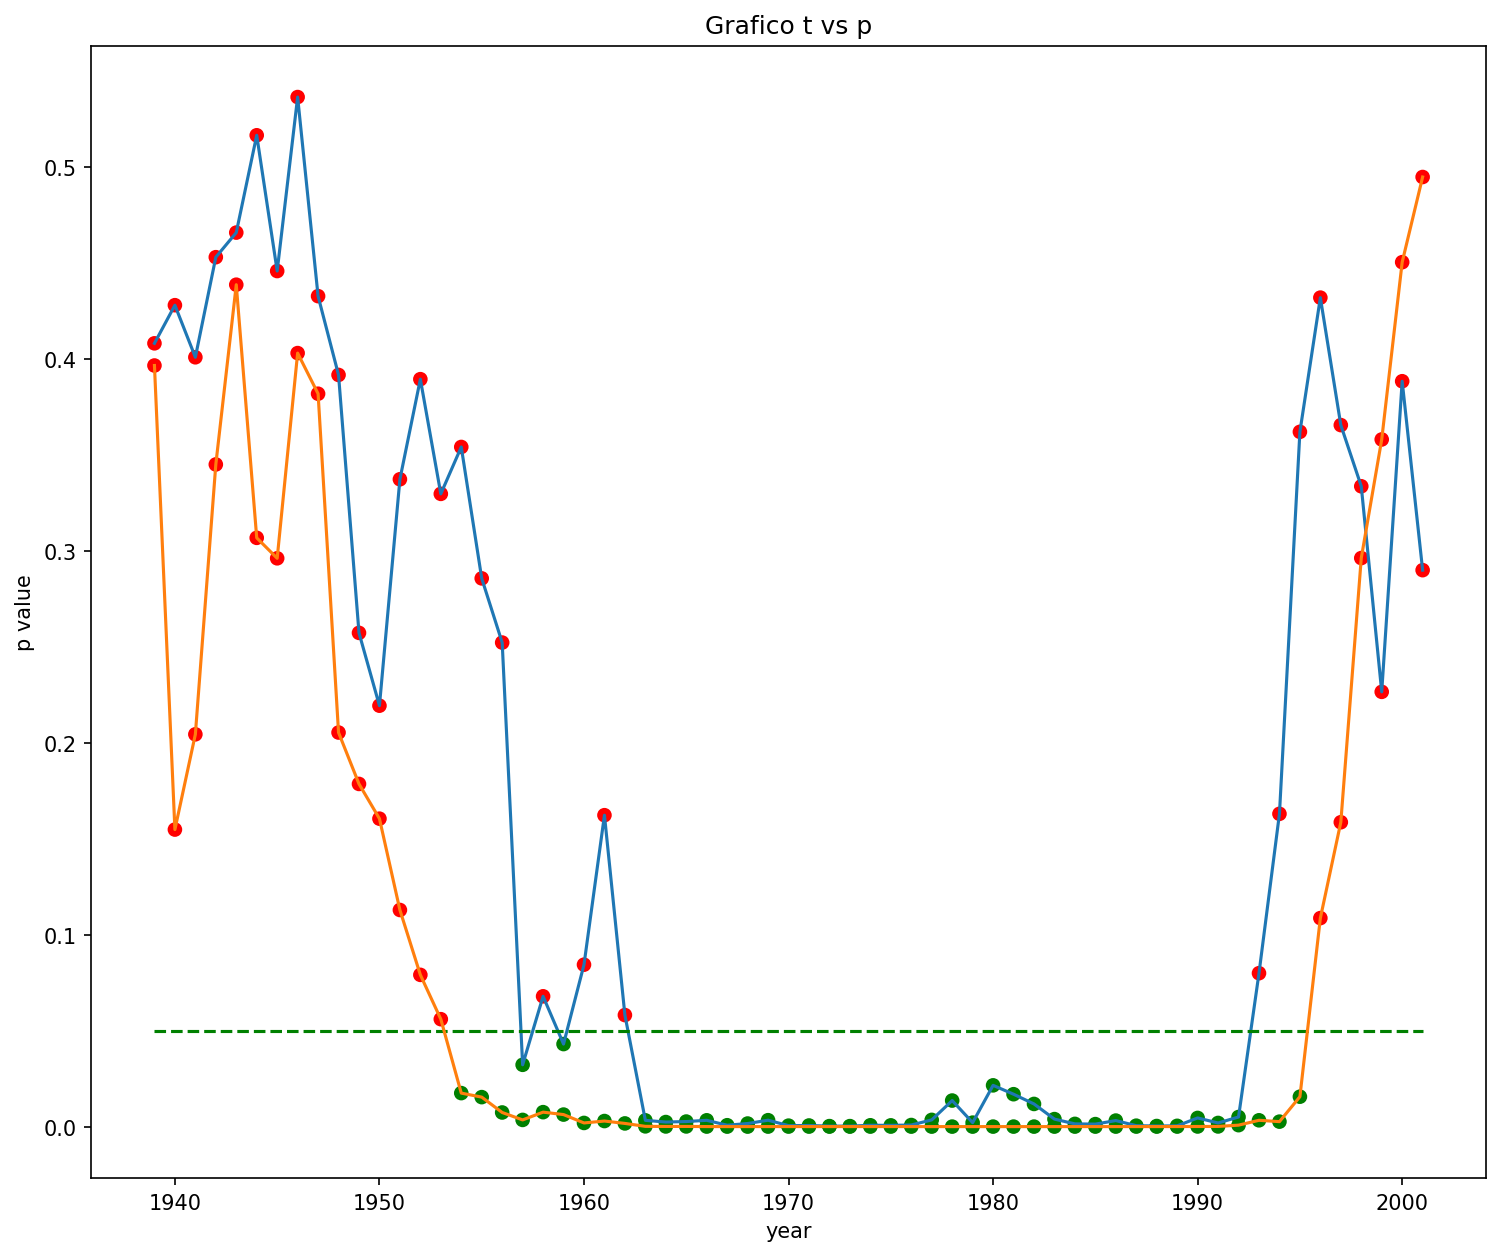

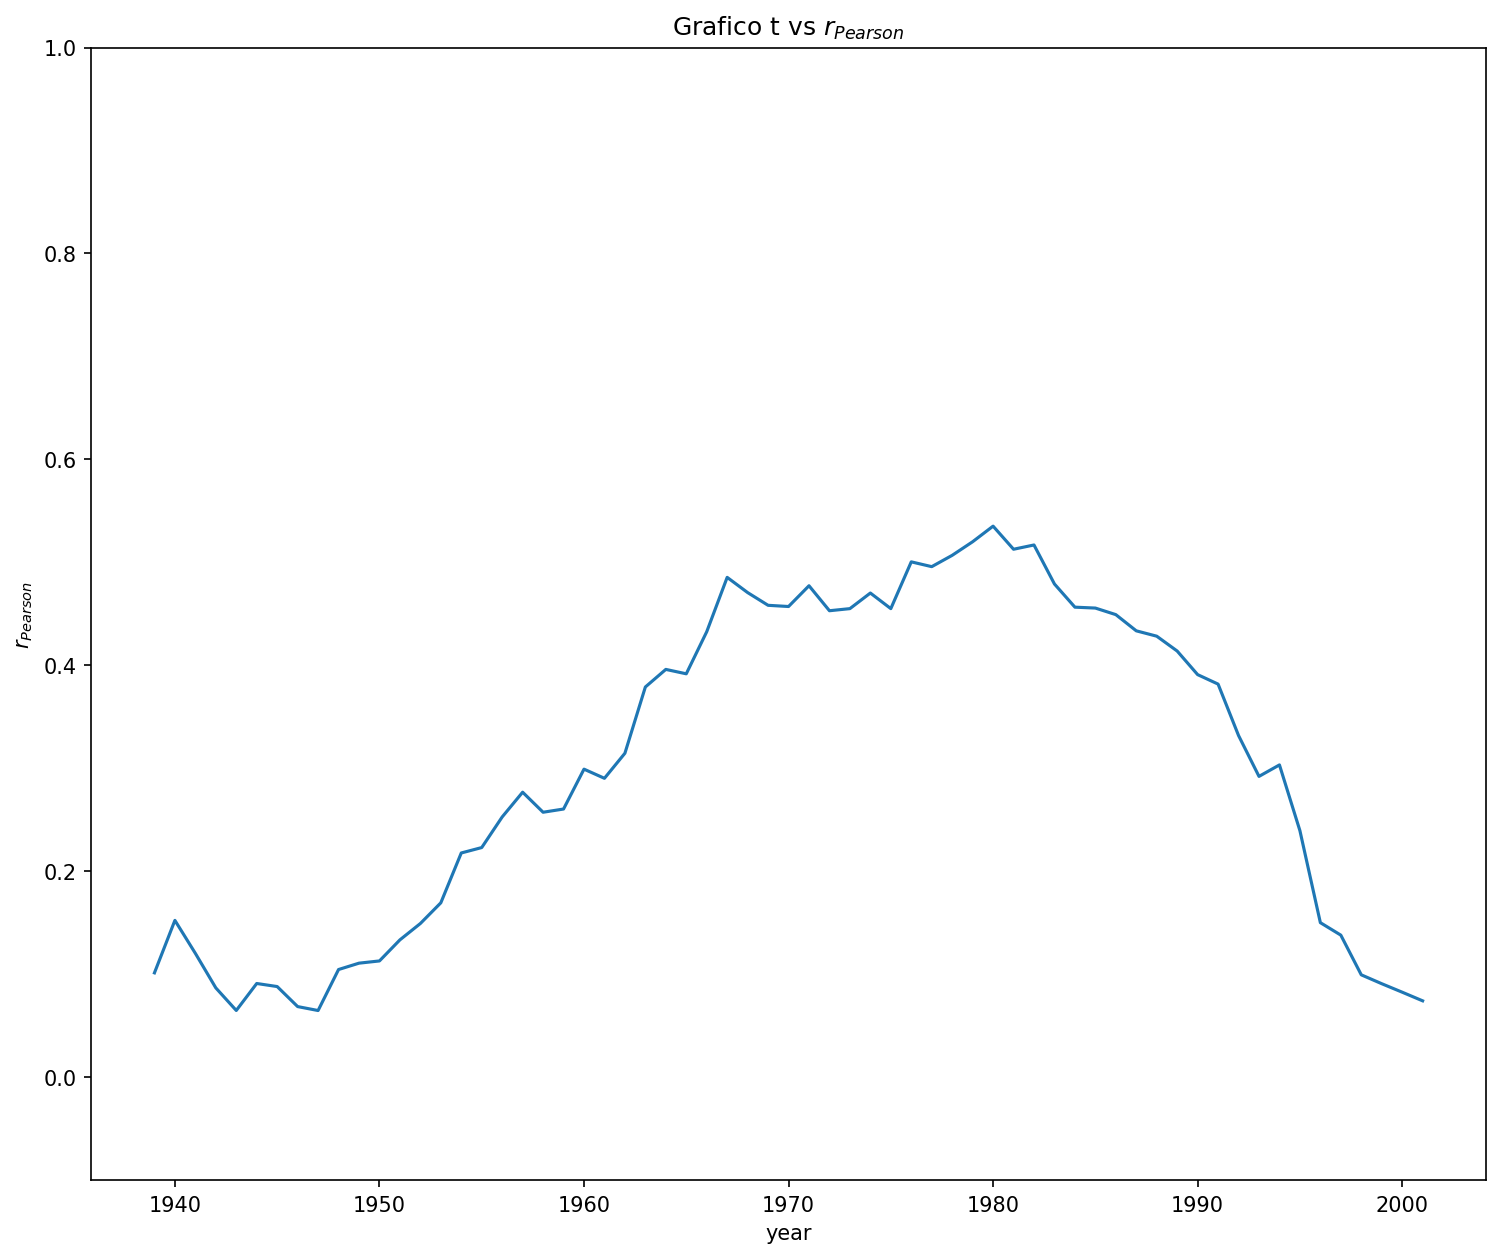

In [61]:
nyears=20
Y1,Y2=1939,2022-nyears
step=1
date=np.arange(Y1,Y2,step)
P=[ (linreg((chi2_test(plot_bar(Y1=y,Y2=y+nyears,numb='1',show=False))[1]).res/np.sqrt(chi2_test(plot_bar(Y1=y,Y2=y+nyears,numb='1',show=False))[1].exp),show=False))[3] for y in date]
C=[(chi2_test(plot_bar(Y1=y,Y2=y+nyears,numb='1',show=False))[0]).p[0] for y in date]
CORR=[pd.Series((chi2_test(plot_bar(Y1=y,Y2=y+nyears,numb='1',show=False))[1]).index).corr( (chi2_test(plot_bar(Y1=y,Y2=y+nyears,numb='1',show=False))[1]).res ) for y in date]
colors=[]
for c in C:
    if c<0.05:
        colors.append('green')
    else:
        colors.append('red')
colors1=[]
for c in P:
    if c<0.05:
        colors1.append('green')
    else:
        colors1.append('red')
plt.figure(figsize=(12,10),dpi=150)
plt.title('Grafico t vs p')
plt.scatter(date,C,c=colors)
plt.plot(date,C,label=r'p_{\chi^2}')
plt.plot([date[0],date[-1]],[0.05,0.05],linestyle='--',color='green')
plt.plot(date,P,label=r'p_{slope}')
plt.scatter(date,P,c=colors1)
plt.ylabel('p value')
plt.xlabel('year')
plt.show()

plt.figure(figsize=(12,10),dpi=150)
plt.title('Grafico t vs $r_{Pearson}$')
plt.plot(date,CORR)
plt.ylabel(r'$r_{Pearson}$')
plt.xlabel('year')
plt.ylim(-0.1,1)
plt.show()

Quello che si nota dalla seguente analisi si può escludere l'ipotesi nulla con significatività $\alpha=0.05$ tra gli anni 1962-2010. Quello che inoltre si nota è che più il set di dati usato contiene estrazioni del 1962 più il p value decresce, suggerendo che, come detto anche in precedenza, le estrazioni in quel lasso temporale non siano uniformi(sempre con la stessa significatività). 

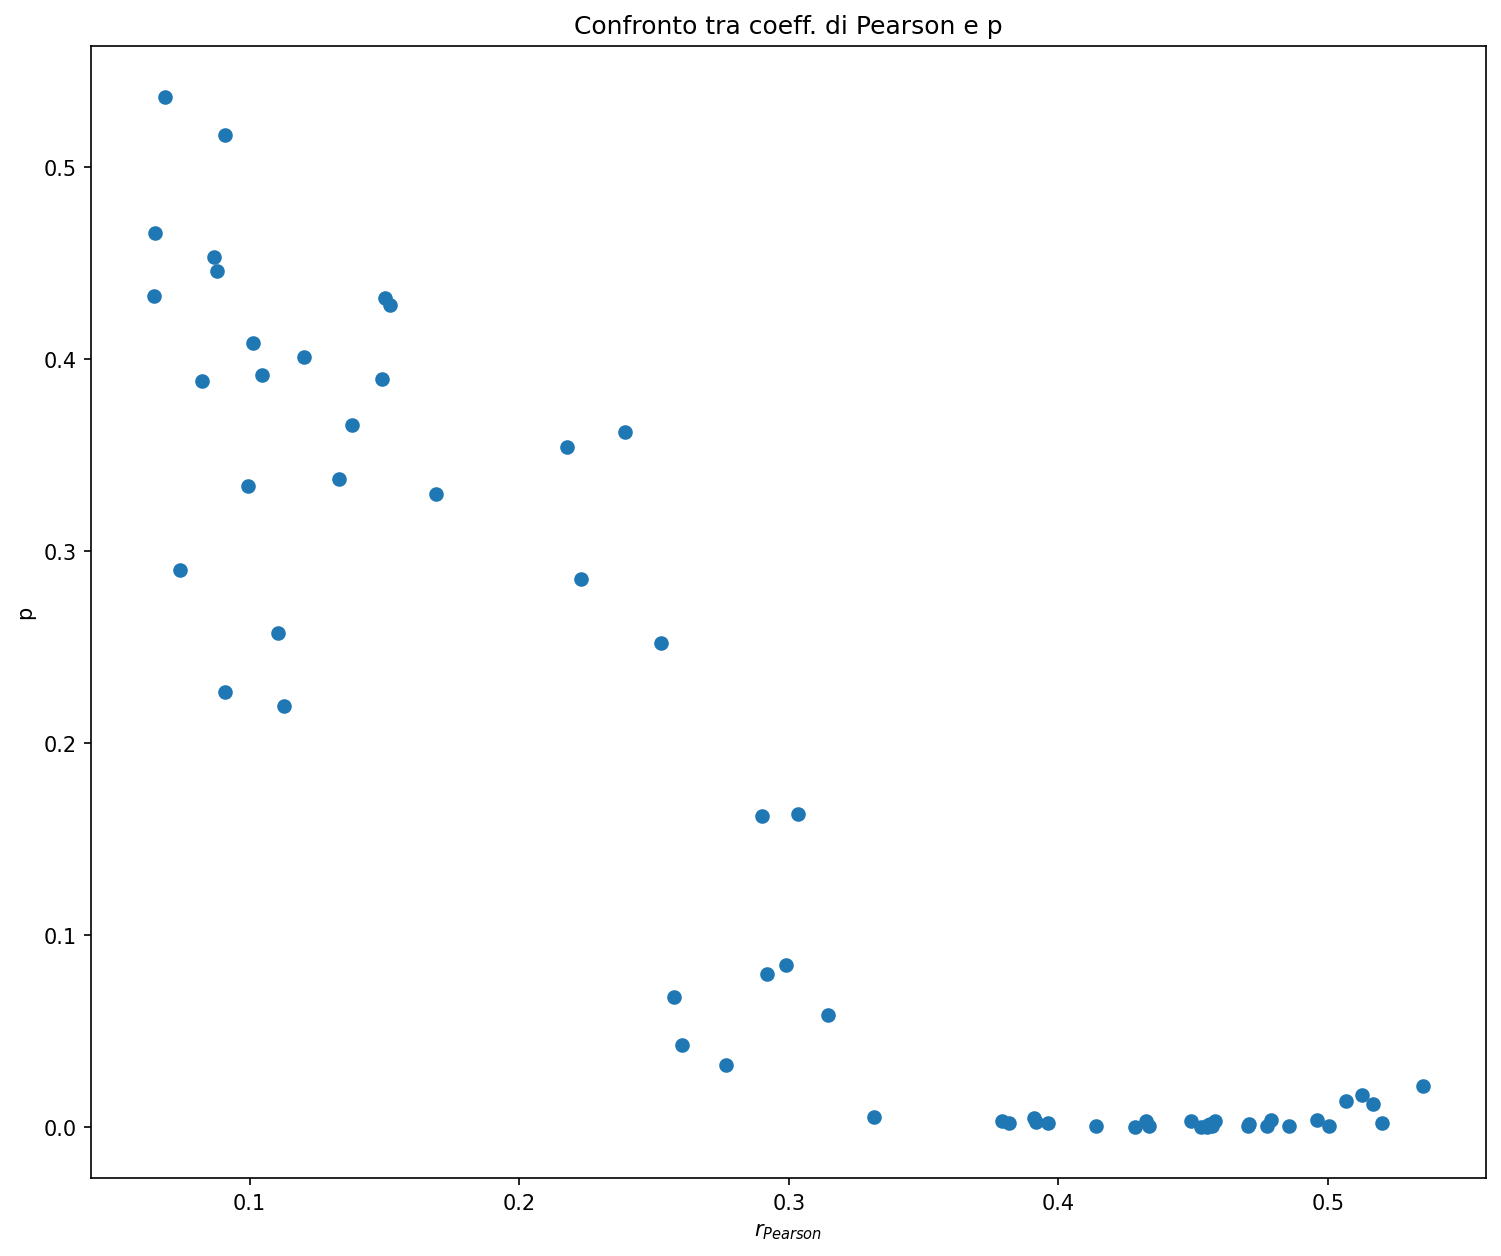

In [29]:
plt.figure(figsize=(12,10),dpi=150)
plt.scatter(CORR,C)
plt.title('Confronto tra coeff. di Pearson e p')
plt.xlabel(r'$r_{Pearson}$')
plt.ylabel('p')
plt.show()

Un'ultima osservazione è che il coefficiente di Pearson tra le frequenze e i numeri estratti nel tempo cresce quando il p value decresce, suggerendo quindi una maggiore correlazione nel lasso temporale prima specificato. 

## Test di Kolmogorov-Smirnov
Come ulteriore analisi, si procede con un test di Kolmogorov per il campione corrispondente alla fascia temporale individuata precedentemente. Si osserva preliminarmente che, come riportato nella documentazione scipy della funzione scipy.stats.kstest, l'implementazione python tramite essa è valida solo per distribuzioni continue. Per eseguire il test, si procede quindi come segue: si determina, preso il campione $\mathcal{S}$ e la cdf attesa $\mathcal{F}(x)$, si considera come nel test classico la funzione $$\mathcal{F}_n(x):=\frac{\# \textrm{ elementi del campione }\le x}{\textrm{dimensione del campione}}$$
Si genera, tramite simulazione Monte Carlo, una distribuzione della variabile $\mathcal{D}:=\sup\vert \mathcal{F}(x)-\mathcal{F}_n(x) \vert$ con numero di elementi del campione $N$ e stabiliremo, posto $\mathcal{D}_{\mathrm{obs}}$ la determinazione della v.c. ottenuta dal campione reale, che il p-value associato al test sia dato dalla frazione relativa di casi nei quali $\mathcal{D}_{\mathrm{test}}>\mathcal{D}_{\mathrm{obs}}$. Spesso il numero di valori da generare per ottenere un p-value diverso da 0 è considerevole (i valori di $\mathcal{D}$ possono essere molto spostati verso la coda destra della distribuzione). Nei casi estremi in cui $\mathrm{obs}$ sia maggiore di tutti i valori simulati si pone $p_{\mathrm{test}}\le\frac{1}{N}$. 

Si prende il campione di dati del primo pescaggio dal 1960 al 2000.

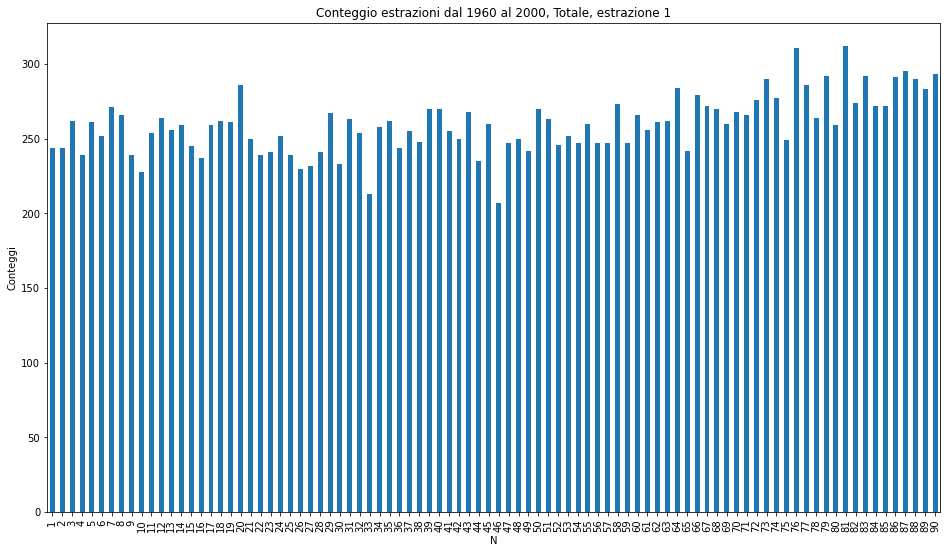

In [64]:
sample=plot_bar(city_name='all',numb='1',Y1=1960,Y2=2000)
s=[]
for i in range(90):
    s+=[sample.index[i]]*sample.values[i]
s=np.array(s)

I risultati del test del $\chi^2$ con $\alpha=0.05$ sono mostrati di seguito.

slope :  0.0016100584184320403 intercept : -0.0732576580386578 r (Pearson) :  0.5661413901636831 p (H0 : slope=0):  6.049572878635023e-09
p value (test del chi quadro): [0.00457496]
p value (test su pendenza): 6.049572878635023e-09


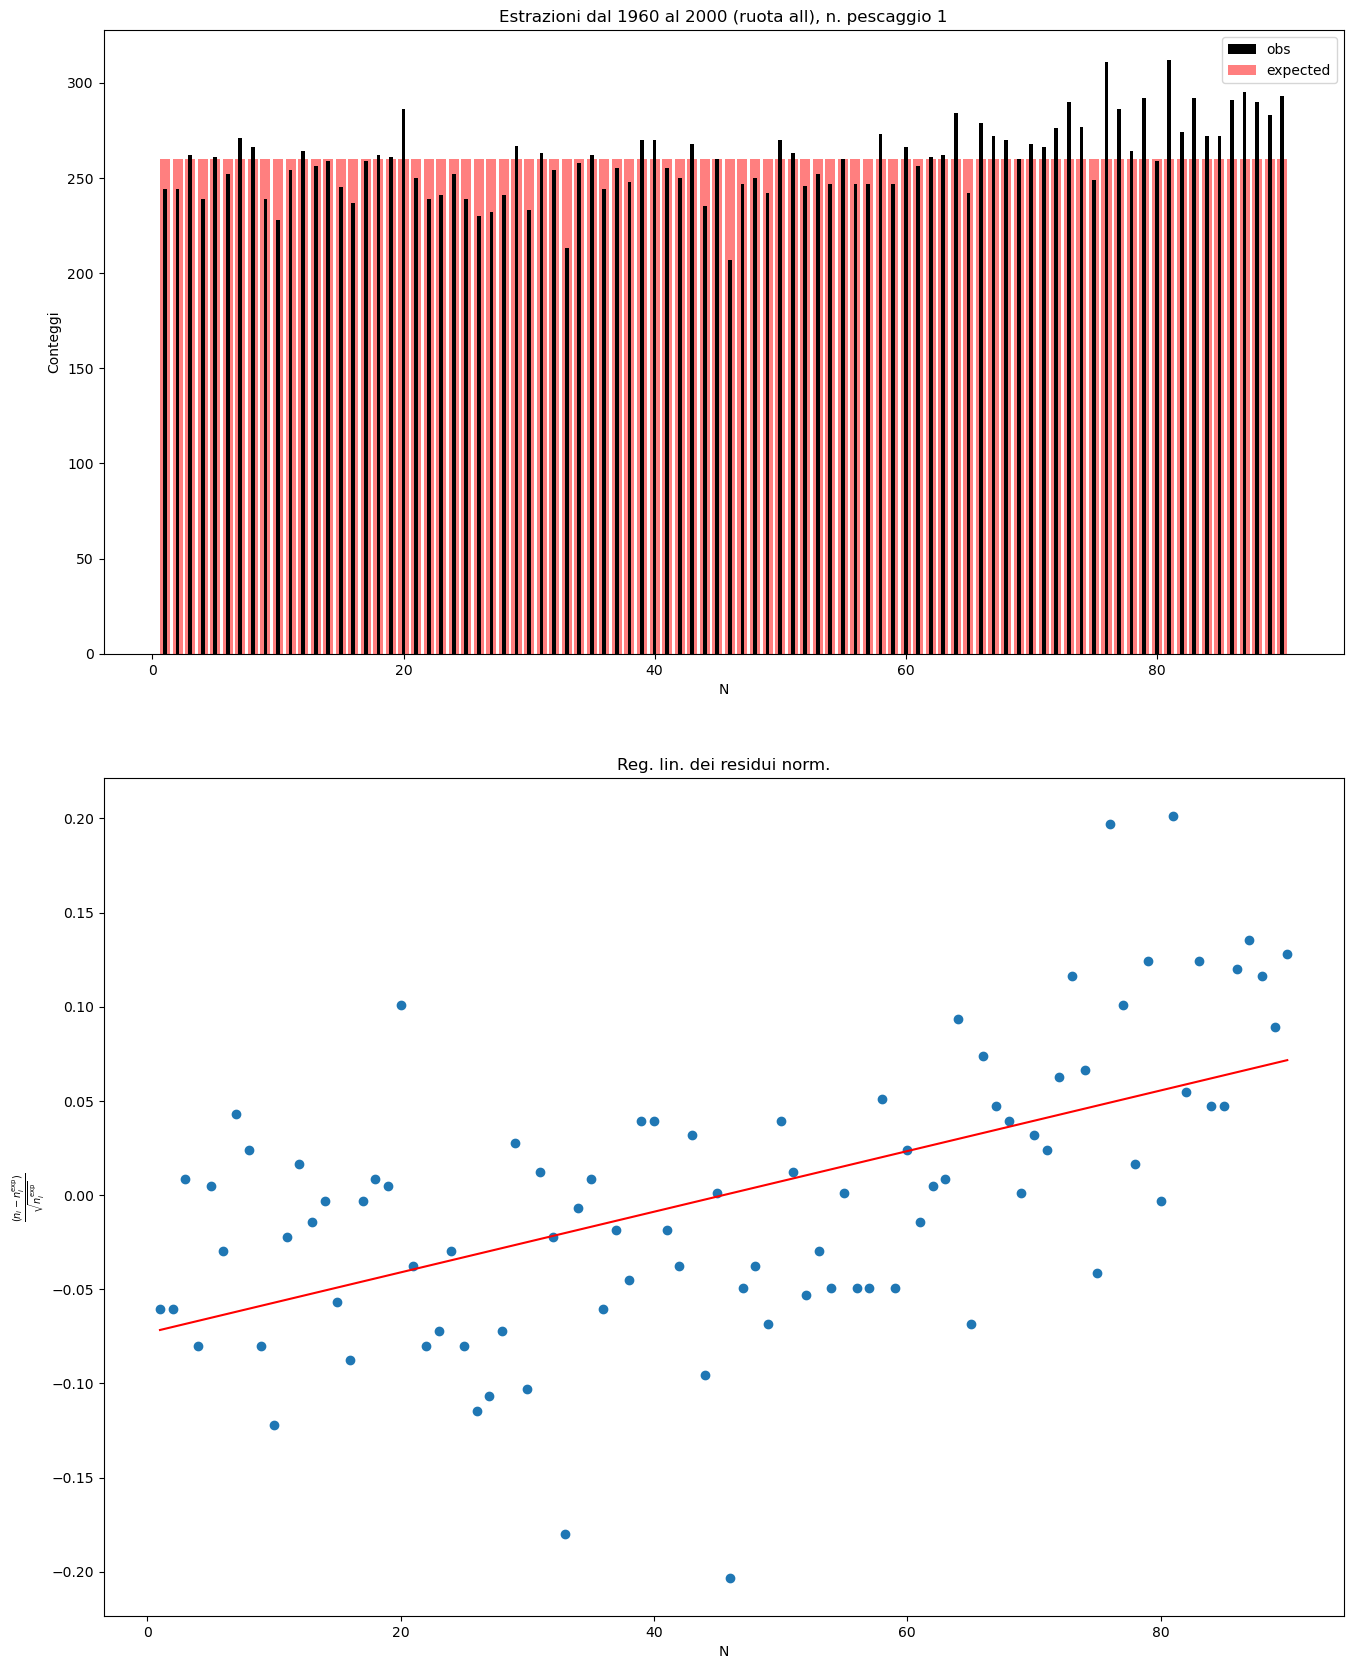

In [65]:
analisi(Y1=1960,Y2=2000,numb='1')

Si procede adesso con la definizione di $\mathcal{F},\mathcal{F}_n$.

In [66]:
model=stats.randint(low=1,high=91,loc=0)
true_cdf=lambda x: model.cdf(x)
def my_cdf(x):
    return len(s[s<=x])/len(s)

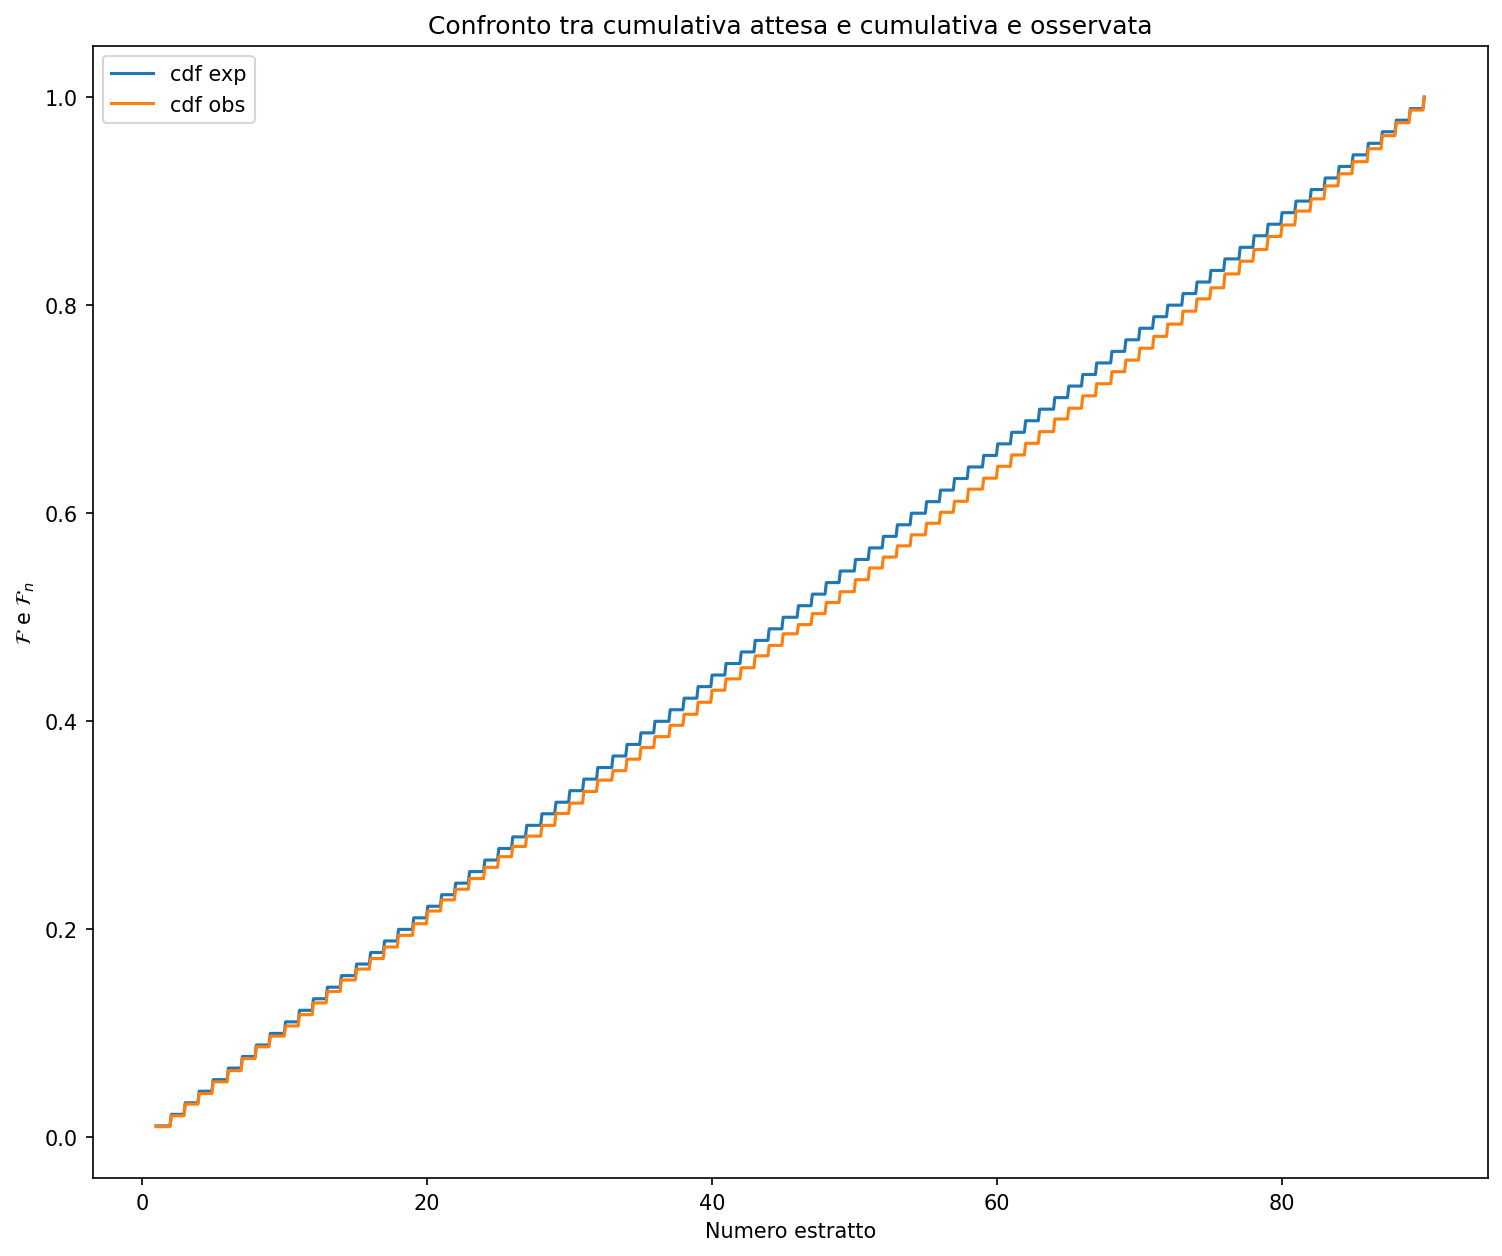

In [67]:
plt.figure(figsize=(12,10),dpi=150)
x0=np.linspace(1,90,1000)
plt.plot(x0,true_cdf(x0),label='cdf exp')
plt.plot(x0,[my_cdf(p) for p in x0],label='cdf obs')
plt.xlabel('Numero estratto')
plt.ylabel(r'$\mathcal{F}$ e $\mathcal{F}_n$')
plt.title('Confronto tra cumulativa attesa e cumulativa e osservata')
plt.legend()
plt.show()

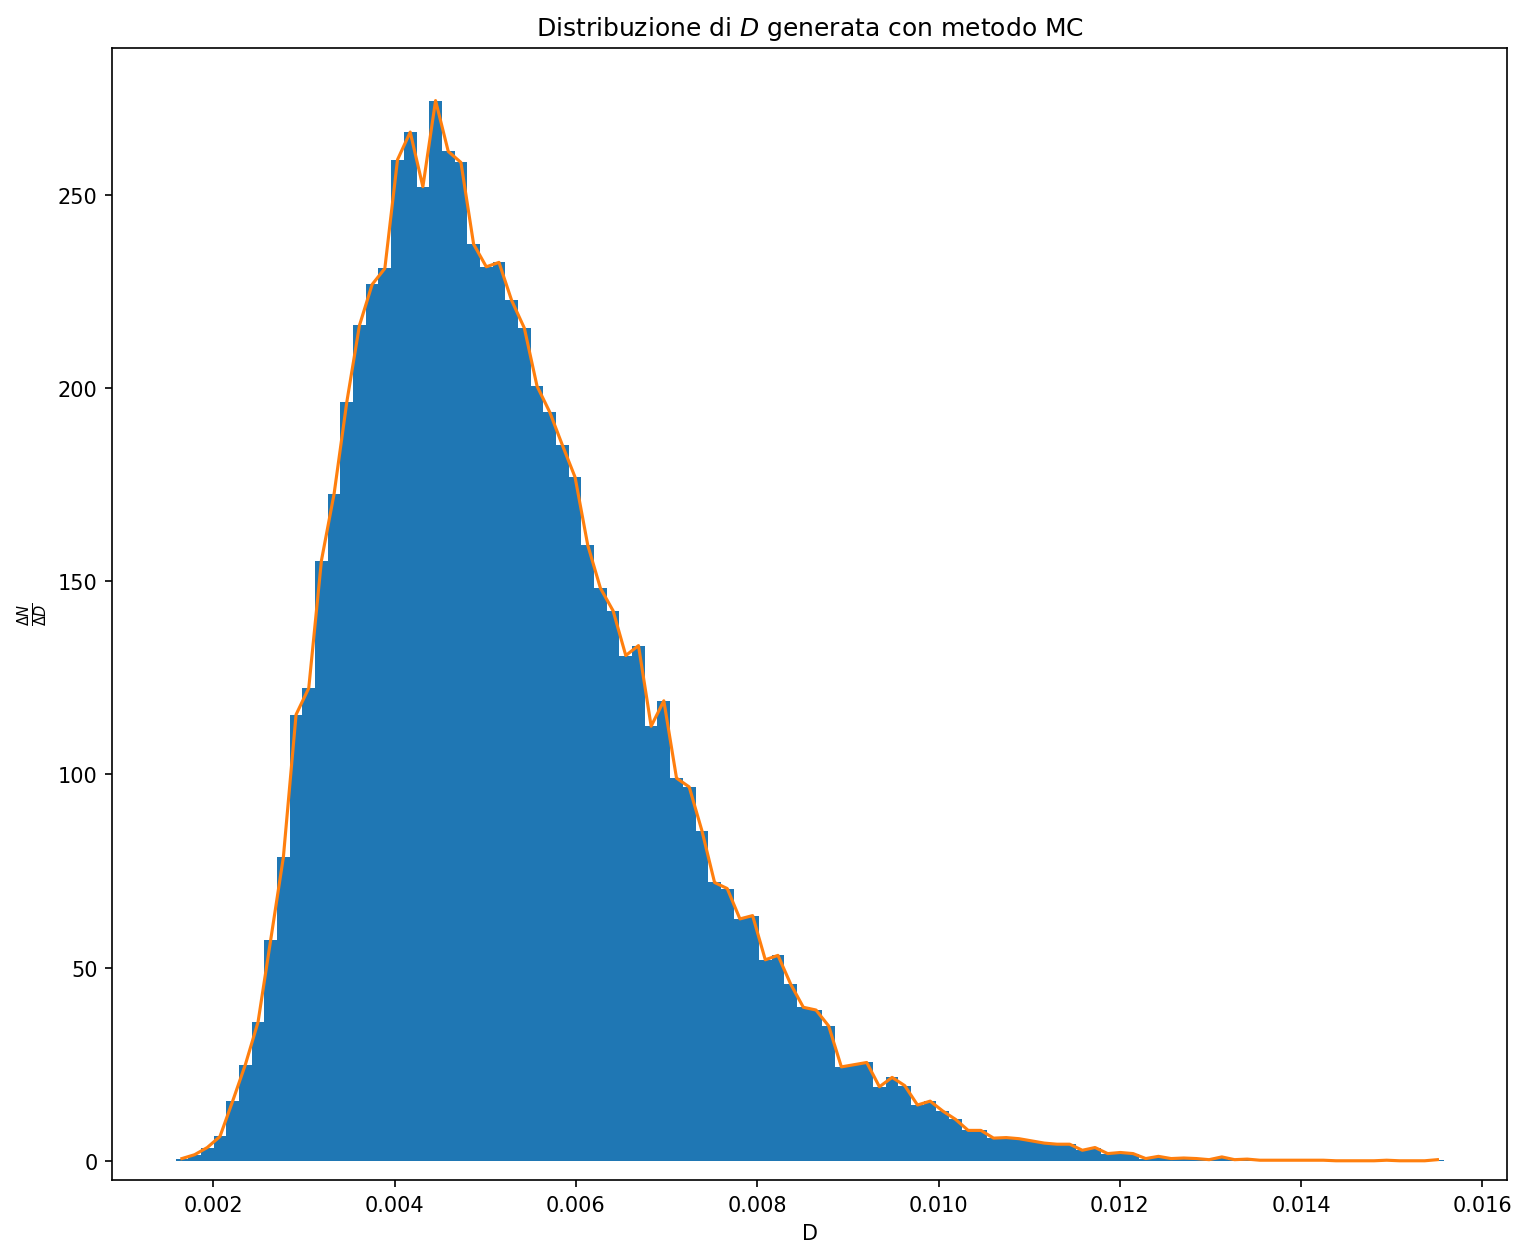

In [34]:
N,n_samp=50000,len(s)
nbins=100
Ds=np.empty(N)
true_cum=true_cdf(np.array(range(1,91)))
for n in range(N):
    samp_n=model.rvs(n_samp)
    numbers=np.array(range(1,91))
    samp_n_cum=np.array([len(samp_n[samp_n==num])/n_samp for num in numbers]).cumsum()
    D=abs(samp_n_cum-true_cum).max()
    Ds[n]=D
plt.figure(figsize=(12,10),dpi=150)
freqs,bins,patches=plt.hist(Ds,nbins,density=True)
cent_vals=bins[:-1]+np.diff(bins)/2
plt.plot(cent_vals,freqs)
plt.title(r'Distribuzione di $D$ generata con metodo MC')
plt.xlabel('D')
plt.ylabel(r'$\frac{\Delta N}{\Delta D}$')
plt.ylim(-5)
plt.show()

Nell'istogramma precedente è riportato il risultato della simulazione con $N=50000$ valori. Si procede con il confronto con le osservazioni sperimentali.

In [35]:
numbers=np.array(range(1,91))
dnumbers=abs(true_cdf(numbers)-np.array([my_cdf(n) for n in numbers]))
Dhat=dnumbers.max()
xD=numbers[dnumbers==Dhat]
print('D_obs= ',Dhat)
p_val=len(Ds[Ds>Dhat])/len(Ds)
if p_val==0:
    print('p_val<={}'.format(1/N))
else:
    print('p_val={}'.format(p_val))

D_obs=  0.02187054462503557
p_val<=2e-05


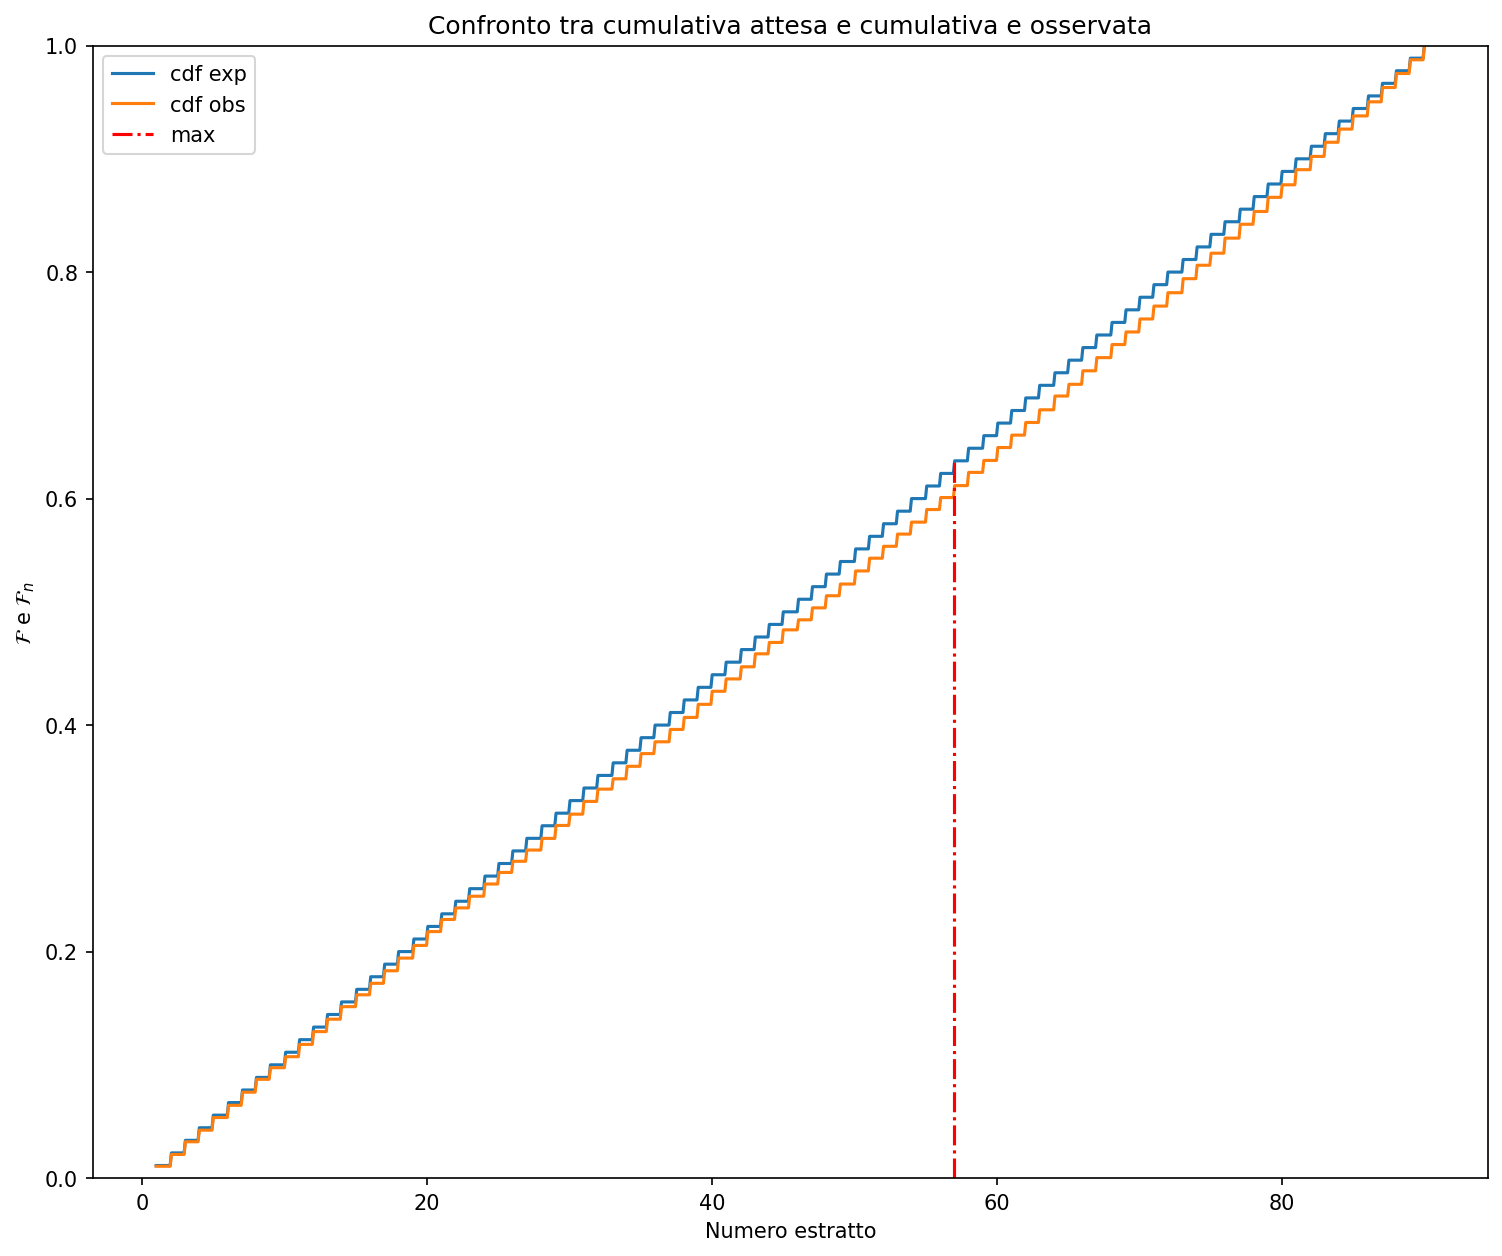

In [36]:
plt.figure(figsize=(12,10),dpi=150)
x0=np.linspace(1,90,1000)
plt.plot(x0,true_cdf(x0),label='cdf exp')
plt.plot(x0,[my_cdf(p) for p in x0],label='cdf obs')
plt.plot([xD[0],xD[0]], [0,true_cdf(xD)[0]], linestyle='-.',color='r',label='max')
plt.xlabel('Numero estratto')
plt.ylabel(r'$\mathcal{F}$ e $\mathcal{F}_n$')
plt.ylim(0,1)
plt.title('Confronto tra cumulativa attesa e cumulativa e osservata')
plt.legend()
plt.show()

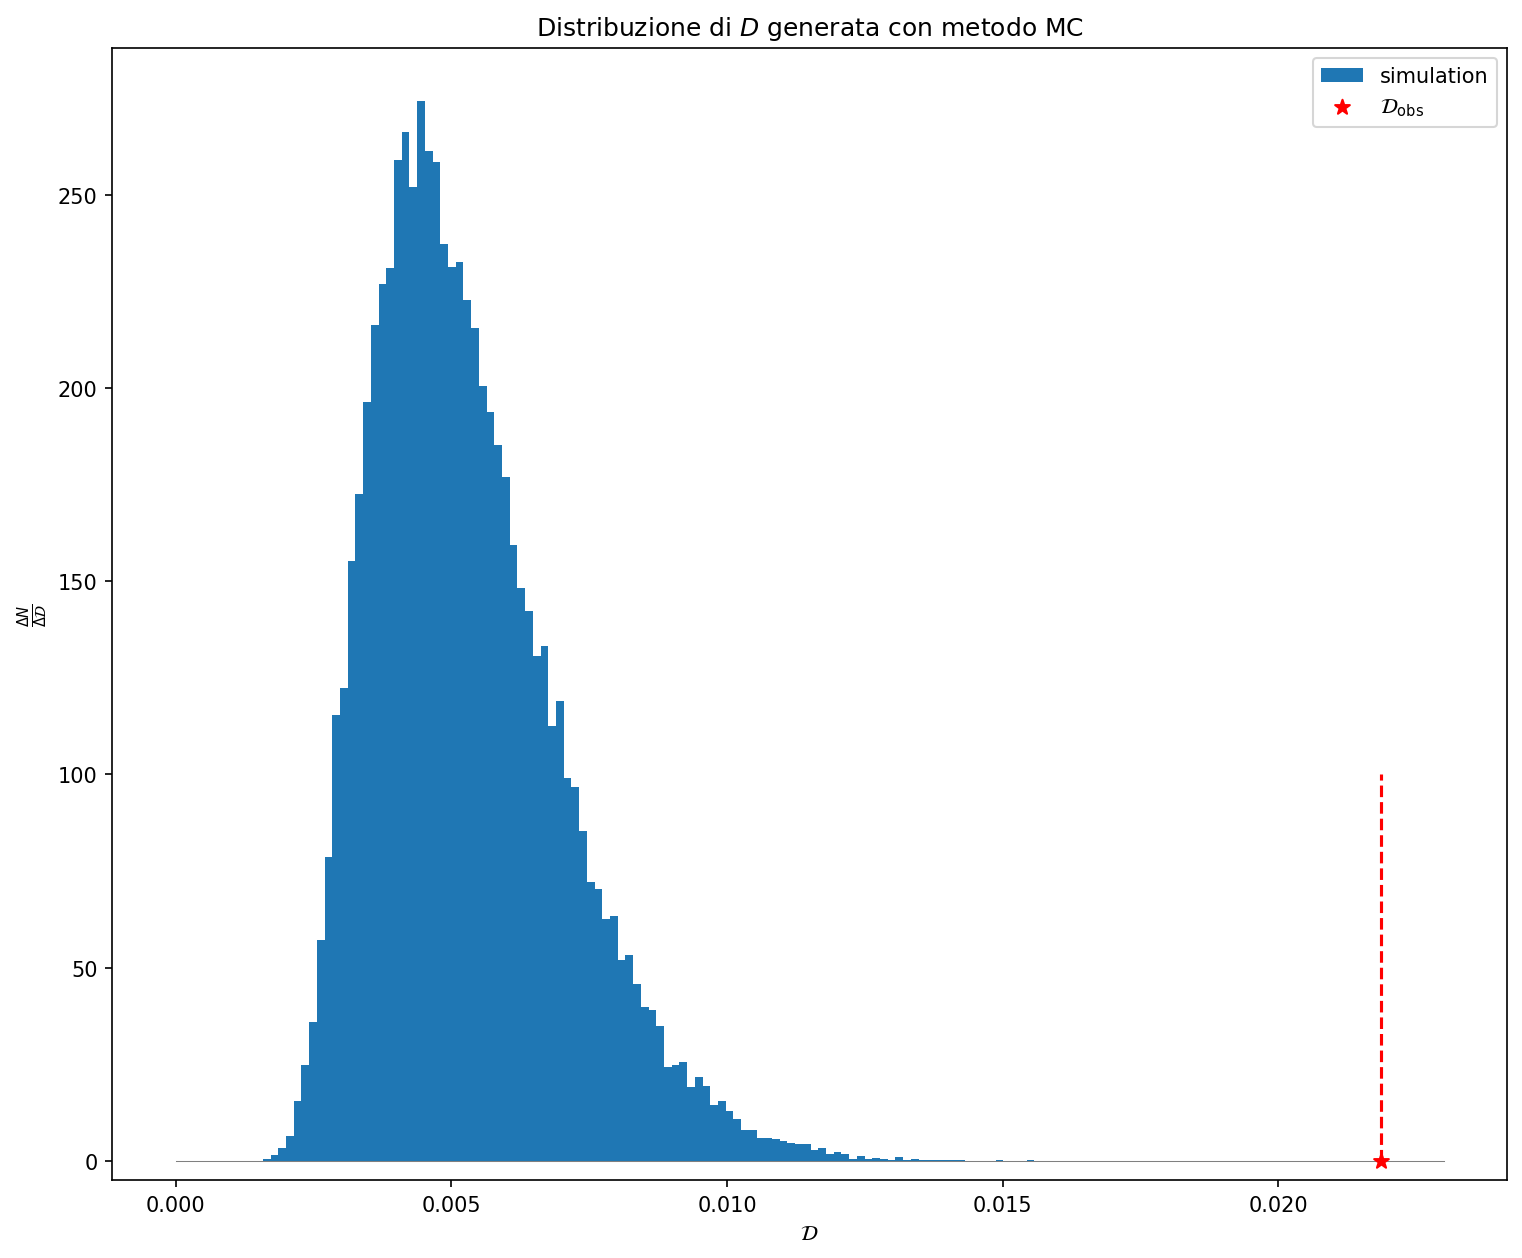

In [37]:
plt.figure(figsize=(12,10),dpi=150)
plt.hist(Ds,nbins,density=True,label='simulation')
plt.scatter([Dhat],[0],s=55,color='r',marker='*',zorder=100,label=r'$\mathcal{D}_{\mathrm{obs}}$')
plt.plot([0,0.023],[0,0],lw=0.5,color='grey')
plt.plot([Dhat,Dhat],[0,100],linestyle='--',c='red')
plt.title(r'Distribuzione di $D$ generata con metodo MC')
plt.xlabel(r'$\mathcal{D}$')
plt.ylabel(r'$\frac{\Delta N}{\Delta \mathcal{D}}$')
plt.ylim(-5)
plt.legend()
plt.show()

Si osserva un valore di $p<1/50000<\alpha$, cioè è possibile rigettare l'ipotesi nulla con significatività del test $\alpha$. 

## Conclusioni
Dall'analisi condotta sui dati relativi alle estrazioni del lotto italiano è risultato preliminarmente che i test del $\chi^2$ condotti non permettessero di rigettare l'ipotesi nulla con significatività $\alpha=0.05$. A partire da considerazione fatte sull'indice di Pearson valutato tra i numeri estratti e le loro frequenze è emerso il sospetto di una tendenza dei numeri più alti a essere estratti con maggiore frequenza. Inoltre, successivi test condotti sugli stessi parametri sulle estrazioni delle ruote prese singolarmente hanno condotto alla conclusione che nessuna delle ruote 'passava' entrambi i test condotti, suggerendo di scartare l'ipotesi che la discrepanza osservata fosse il risultato di un difetto di una di queste; dall'analisi sui singoli pescaggi è emersa una sensibilità maggiore di questo effetto sul primo pescaggio, per il quale si sono riscontrati bassi valori di $p_{\chi^2},\,p_{slope}$. L'analisi di vari sotto-campioni in funzione del tempo ha permesso di concludere che esista una regione temporale entro la quale i test condotti permettano di escludere l'ipotesi nulla di uniformità dei dati con significatività $\alpha=0.05$ e contemporaneamente scartare l'ipotesi nulla che la pendenza della retta di regressione fosse nulla. Con un ulteriore test (Kolmogorov_Smirnov) si è corroborata questa conclusione.

Scritto da:
## Chirico Paolo (N85001826) 
## Puca Giuseppe (N85001750)

## Riferimenti
[*Documentazione Scipy*](https://docs.scipy.org/doc/scipy/index.html) \
[*Documentazione Matplotlib*](https://matplotlib.org/)\
[*Appunti del corso di analisi statistica dei dati sperimentali*](https://github.com/lucalista/analisi-dati-2022) \
[*Documentazione Pandas*](https://pandas.pydata.org/pandas-docs/stable/)
